# Energy Portfolio Optimization for Switzerland 2050

This notebook implements a comprehensive energy portfolio optimization framework with four main sections:

0. **External Data Overview** - Visualization of all input data (solar, wind, prices, etc.)
1. **Dispatch Simulation** - Full year hourly dispatch of energy production and storage
2. **Genetic Optimizer** - Multi-objective optimization using genetic algorithms
3. **Pareto Frontier Analysis** - 3D Pareto frontier identification and visualization

### Key Changes (v2.0):
- **Palm oil only**: Biooil storage removed; Palm oil is the only imported bio-fuel
- **Aviation fuel from Fuel Tank**: Synthetic fuel supplies aviation (23 TWh/year)
- **Dynamic pricing**: Palm oil prices from futures data (USD/ton → CHF/MWh)
- **Water inflow to lakes**: Precipitation-based inflow at 0.9 kWh/m³
- **EUR→CHF conversion**: Spot prices converted using daily exchange rates
- **LCOE from analysis file**: Pre-computed efficiency and costs with parallelism

---


In [87]:
# =============================================================================
# IMPORTS - Run this cell first
# =============================================================================

# Standard library
import os
import sys
import json
import warnings
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional, Any

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D

# Progress tracking
from tqdm.notebook import tqdm

# Interactive widgets
try:
    import ipywidgets as widgets
    from ipywidgets import Dropdown, Button, Output, VBox, HBox, Layout, Label, IntSlider
    HAS_WIDGETS = True
except ImportError:
    HAS_WIDGETS = False
    print("⚠️ ipywidgets not installed. Run: pip install ipywidgets")

# Suppress warnings
warnings.filterwarnings('ignore')

# =============================================================================
# RELOAD MODULES - Run this to reload all project modules without restarting kernel
# =============================================================================
import importlib

# Reload all project-specific modules
importlib.reload(sys.modules.get('config', importlib.import_module('config')))
importlib.reload(sys.modules.get('data_loader', importlib.import_module('data_loader')))
importlib.reload(sys.modules.get('ppu_framework', importlib.import_module('ppu_framework')))
importlib.reload(sys.modules.get('dispatch_engine', importlib.import_module('dispatch_engine')))
importlib.reload(sys.modules.get('optimization', importlib.import_module('optimization')))
importlib.reload(sys.modules.get('portfolio_metrics', importlib.import_module('portfolio_metrics')))
importlib.reload(sys.modules.get('risk_calculator', importlib.import_module('risk_calculator')))
importlib.reload(sys.modules.get('multi_objective_explorer', importlib.import_module('multi_objective_explorer')))
importlib.reload(sys.modules.get('pareto_frontier', importlib.import_module('pareto_frontier')))
importlib.reload(sys.modules.get('visualization', importlib.import_module('visualization')))
importlib.reload(sys.modules.get('frontier_research', importlib.import_module('frontier_research')))

# Re-import after reload
from config import Config, DEFAULT_CONFIG
from data_loader import load_all_data, CachedData
from ppu_framework import (
    load_all_ppu_data, Portfolio, create_ppu_dictionary,
    estimate_annual_production, check_energy_sovereignty
)
from dispatch_engine import (
    run_dispatch_simulation, initialize_storage_state,
    compute_scenario_cost
)
from optimization import (
    evaluate_portfolio_full_year, Individual,
    run_genetic_algorithm, FullYearResults
)
from portfolio_metrics import (
    PortfolioMetrics3D, calculate_portfolio_metrics_3d
)
from risk_calculator import RiskCalculator
from multi_objective_explorer import (
    MultiObjectiveGA, ObjectiveConfig,
    explore_and_find_frontier, continue_exploration_3d_frontier
)
from pareto_frontier import (
    find_and_plot_efficiency_frontier,
    load_frontier_from_csv,
    plot_efficiency_frontier,
    extract_pareto_frontier_from_df
)
from visualization import (
    plot_fitness_evolution, plot_portfolio_composition,
    plot_dispatch_scenario, create_optimization_dashboard,
    plot_demand_volatility, plot_spot_price_volatility,
    plot_energy_balance_distribution, plot_full_year_overview,
    plot_full_year_storage, plot_full_year_production_by_source
)
from frontier_research import (
    run_frontier_research, FrontierResearchConfig, FrontierResearchResults
)


# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Create output directories
os.makedirs('data/result_plots', exist_ok=True)


print("✅ All imports successful!")
print(f"   Config loaded: {type(DEFAULT_CONFIG).__name__}")
print(f"   Widgets available: {HAS_WIDGETS}")
print("   🔄 Modules reloaded - changes will take effect immediately")


IndentationError: expected an indented block after 'if' statement on line 1395 (dispatch_engine.py, line 1396)

In [ ]:
# =============================================================================
# LOAD DATA - Run after imports
# =============================================================================

print("Loading system data...")
config = DEFAULT_CONFIG
cached_data = load_all_data(config=config, force_reload=True)

# Load PPU definitions (returns tuple: cost_df, constructs_df, ppu_definitions)
cost_df, ppu_df, ppu_definitions = load_all_ppu_data(config=config)
risk_calc = RiskCalculator(config=config)

print(f"\n✅ Data loaded successfully!")
print(f"   Demand data: {len(cached_data.get_demand())} hours")
print(f"   Spot prices: {len(cached_data.get_spot_prices())} hours (EUR→CHF converted)")
print(f"   Palm oil prices: {len(cached_data.palm_oil_chf_mwh)} days")
print(f"   Water inflow: {len(cached_data.water_inflow_mwh)} hours ({cached_data.water_inflow_mwh.sum()/1e6:.2f} TWh/year)")
print(f"   Exchange rates: EUR/CHF ({len(cached_data.eur_chf_daily)} days), USD/CHF ({len(cached_data.usd_chf_daily)} days)")
print(f"   PPU types: {len(ppu_definitions)} defined (LCOE from analysis file)")


Loading system data...
Loading data files...
  - Solar incidence: (9072, 1150)
  - Wind data loaded (mean: 1.3 m/s, no scaling)
  - Wind incidence: (9072, 1150)
  - Spot prices (EUR): (8784,)
  - Demand: (8784,)
  - Hydro data loaded
  - Cost data loaded (LCOE: 26 PPUs)
  - EUR/CHF rates: 366 days
  - Palm oil prices (CHF/MWh): 366 days, avg 100.79
  - Water inflow: 8784 hours, total 42.74 TWh
  - Spot prices converted to CHF: avg 72.07 CHF/MWh
  - Aligned all data to 8784 timesteps (366 days)
Data loading complete! (Demand scenario: 2024, multiplier: 1.0x)

✅ Data loaded successfully!
   Demand data: 8784 hours
   Spot prices: 8784 hours (EUR→CHF converted)
   Palm oil prices: 366 days
   Water inflow: 8784 hours (42.74 TWh/year)
   Exchange rates: EUR/CHF (366 days), USD/CHF (366 days)
   PPU types: 26 defined (LCOE from analysis file)


---

# Section 0: External Data Overview

This section provides an overview of all external input data used in the energy portfolio optimization:

1. **Solar Irradiance** - Hourly solar irradiance across ~1150 Swiss locations
2. **Wind Speed** - Hourly wind speeds across ~1150 Swiss locations  
3. **Run of River** - Monthly hydropower production from run-of-river plants
4. **Electricity Spot Price** - Hourly Swiss electricity spot prices (converted EUR→CHF)
5. **Palm Oil Prices** - Daily palm oil futures prices (USD/ton → CHF/MWh)
6. **Water Inflow to Lakes** - Hourly precipitation-based water inflow (m³ → MWh)
7. **Currency Exchange Rates** - EUR/CHF and USD/CHF daily rates

### Data Sources:
- **Solar/Wind**: Open-Meteo Archive API (ERA5 reanalysis, 0.1° × 0.1° grid)
- **Spot Prices**: ENTSO-E (Swiss day-ahead prices in EUR/MWh)
- **Palm Oil**: REA Holdings share prices (proxy for palm oil futures)
- **Water Inflow**: Open-Meteo precipitation data with 0.9 kWh/m³ conversion factor
- **Exchange Rates**: Dukascopy (USD/CHF) and ECB reference rates (EUR/CHF)


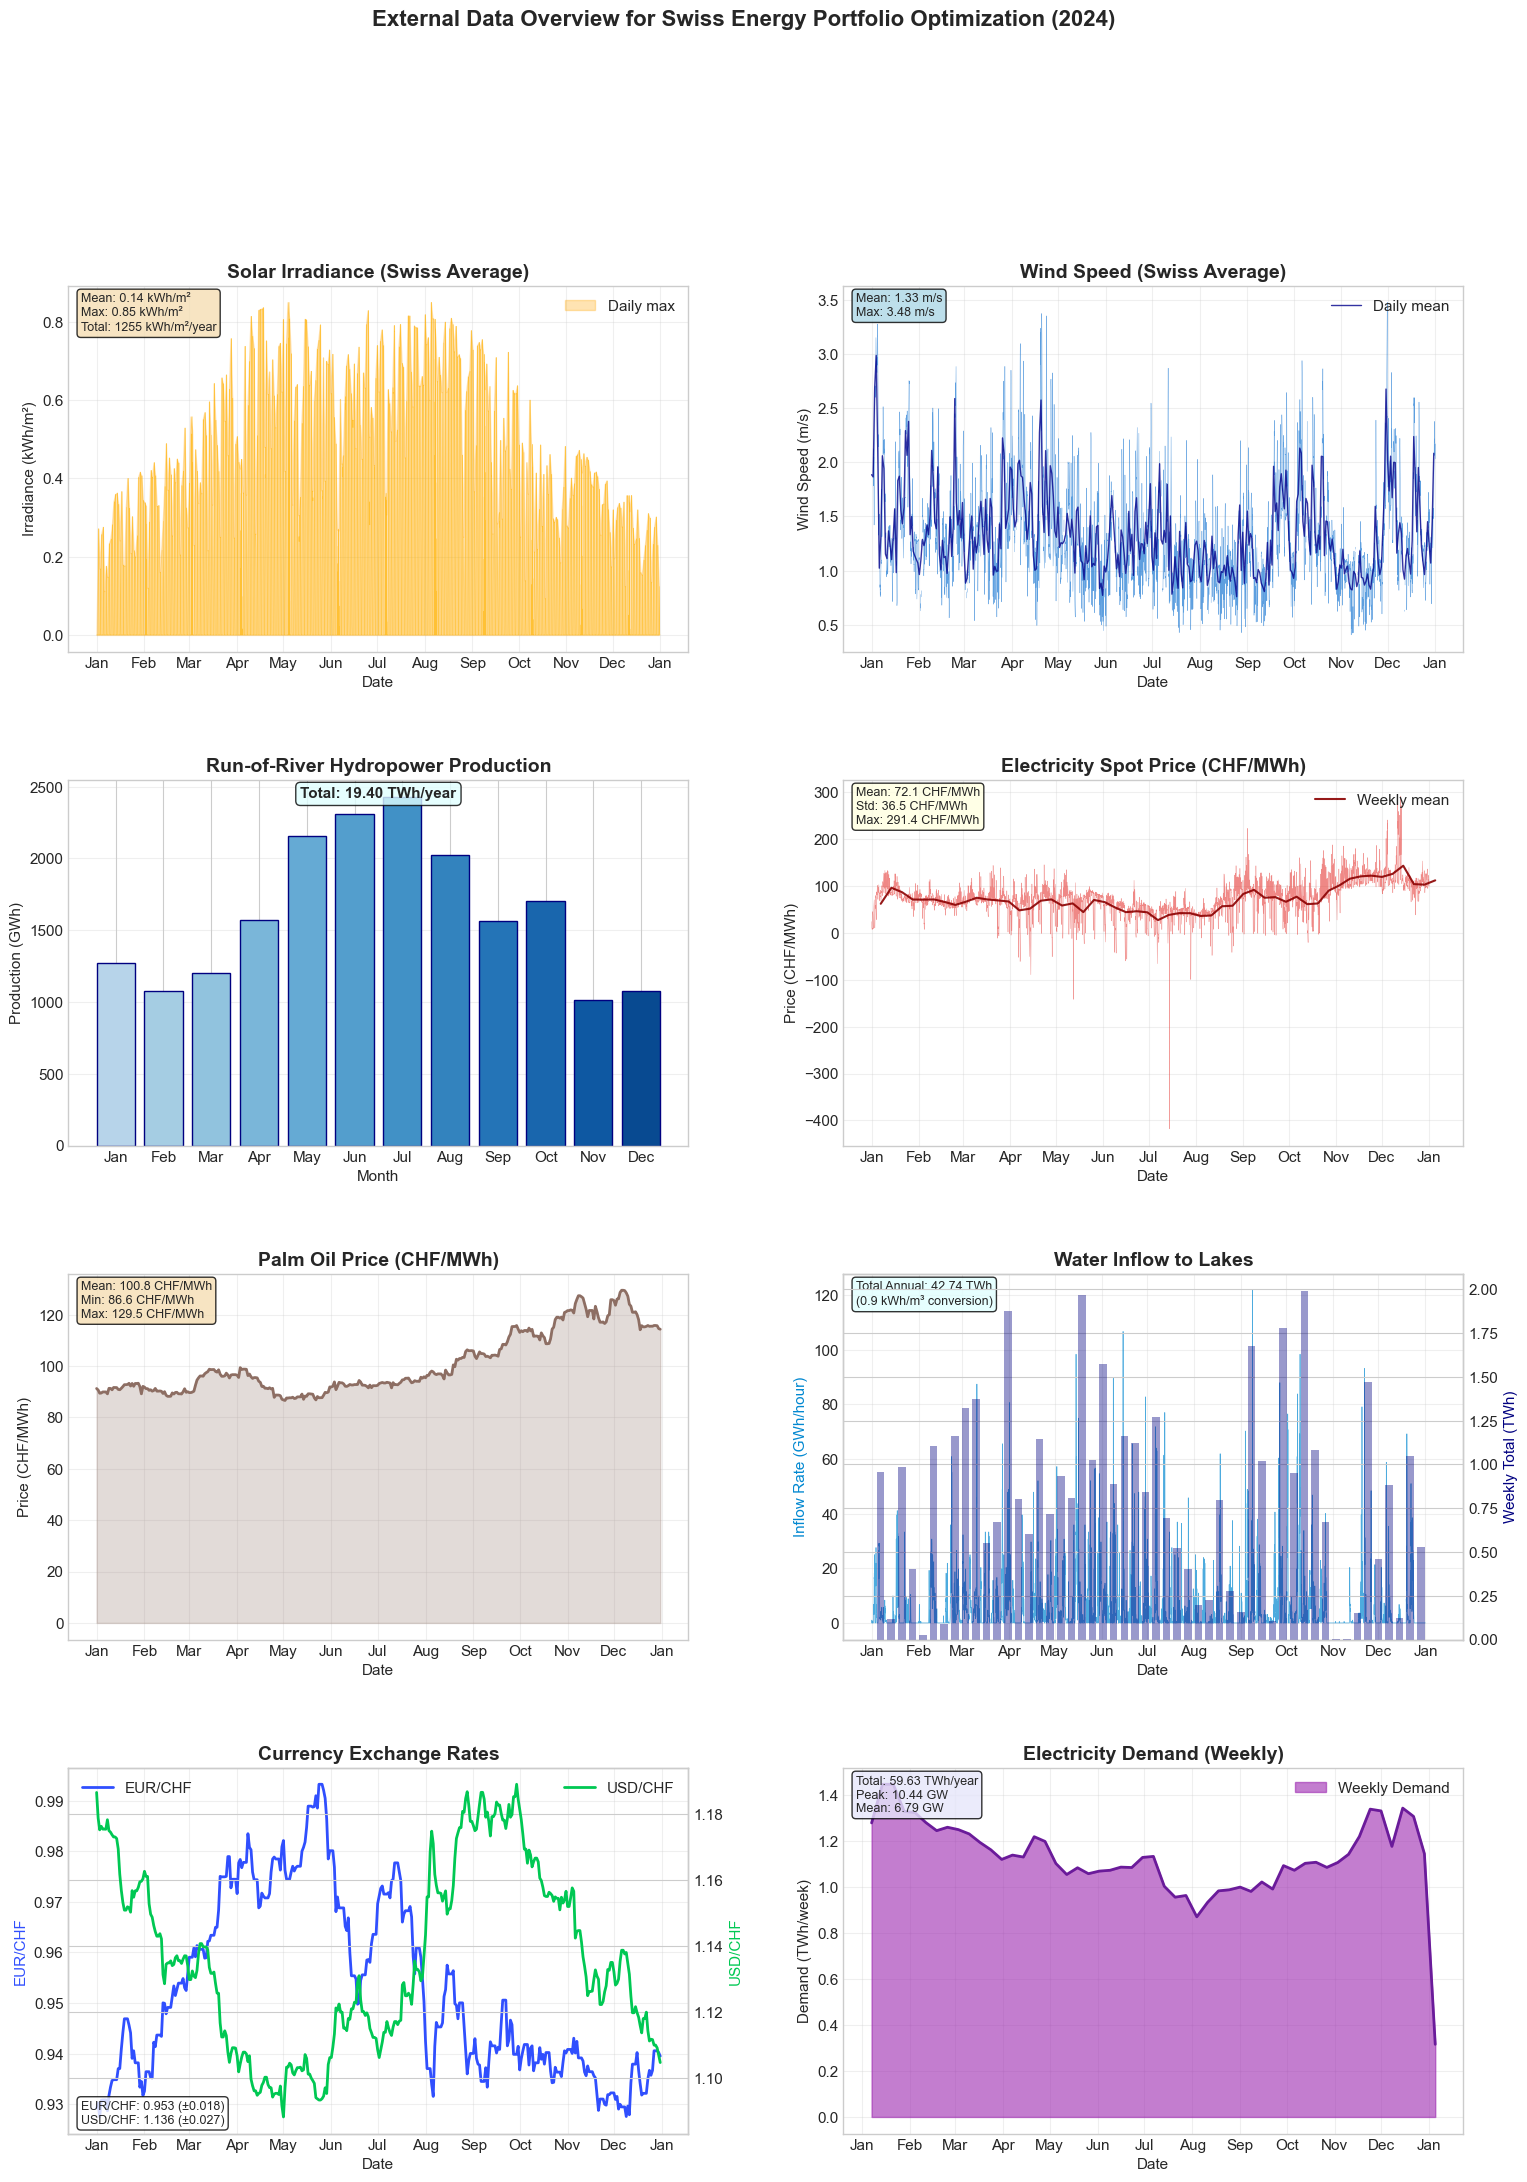


✅ External data overview saved to: data/result_plots/external_data_overview.png


In [ ]:
# =============================================================================
# SECTION 0: EXTERNAL DATA OVERVIEW
# =============================================================================
# This cell generates overview plots for all external input data

# Create time indices
n_hours = len(cached_data.get_demand())
hours = pd.date_range('2024-01-01', periods=n_hours, freq='h')
days = pd.date_range('2024-01-01', periods=366, freq='D')

# Get data
solar_data = cached_data.get_solar_incidence(copy=False)
wind_data = cached_data.get_wind_incidence(copy=False)
spot_prices = cached_data.get_spot_prices(copy=False)
demand = cached_data.get_demand(copy=False)
water_inflow = cached_data.get_water_inflow(copy=False)
palm_oil_prices = cached_data.get_palm_oil_prices_daily(copy=False)
eur_chf = cached_data.eur_chf_daily
usd_chf = cached_data.usd_chf_daily
ror_production = cached_data.ror_production  # Monthly RoR

# Calculate spatial averages for solar and wind
solar_avg = np.nanmean(solar_data, axis=1)  # Average across locations per hour
wind_avg = np.nanmean(wind_data, axis=1)    # Average across locations per hour

# Create figure with subplots
fig = plt.figure(figsize=(18, 24))
gs = fig.add_gridspec(4, 2, hspace=0.35, wspace=0.25)

# -----------------------------------------------------------------------------
# Plot 1: Solar Irradiance (kWh/m²)
# -----------------------------------------------------------------------------
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(hours[:len(solar_avg)], solar_avg, color='#FFB300', alpha=0.7, linewidth=0.3)
# Add daily max envelope
daily_max = pd.Series(solar_avg[:len(hours)], index=hours[:len(solar_avg)]).resample('D').max()
ax1.fill_between(daily_max.index, daily_max.values, alpha=0.3, color='orange', label='Daily max')
ax1.set_title('Solar Irradiance (Swiss Average)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Irradiance (kWh/m²)')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Stats box
stats_text = f"Mean: {np.nanmean(solar_avg):.2f} kWh/m²\nMax: {np.nanmax(solar_avg):.2f} kWh/m²\nTotal: {np.nansum(solar_avg):.0f} kWh/m²/year"
ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# -----------------------------------------------------------------------------
# Plot 2: Wind Speed (m/s)
# -----------------------------------------------------------------------------
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(hours[:len(wind_avg)], wind_avg, color='#1976D2', alpha=0.7, linewidth=0.3)
# Add daily mean
daily_mean_wind = pd.Series(wind_avg[:len(hours)], index=hours[:len(wind_avg)]).resample('D').mean()
ax2.plot(daily_mean_wind.index, daily_mean_wind.values, color='darkblue', alpha=0.8, linewidth=1, label='Daily mean')
ax2.set_title('Wind Speed (Swiss Average)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Wind Speed (m/s)')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Stats box
stats_text = f"Mean: {np.nanmean(wind_avg):.2f} m/s\nMax: {np.nanmax(wind_avg):.2f} m/s"
ax2.text(0.02, 0.98, stats_text, transform=ax2.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# -----------------------------------------------------------------------------
# Plot 3: Run of River (Monthly)
# -----------------------------------------------------------------------------
ax3 = fig.add_subplot(gs[1, 0])
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
from matplotlib import cm
colors_ror = cm.get_cmap('Blues')(np.linspace(0.3, 0.9, 12))
bars = ax3.bar(months, ror_production[:12], color=colors_ror, edgecolor='navy', linewidth=1)
ax3.set_title('Run-of-River Hydropower Production', fontsize=14, fontweight='bold')
ax3.set_xlabel('Month')
ax3.set_ylabel('Production (GWh)')
ax3.grid(True, alpha=0.3, axis='y')

# Add total annotation
total_ror = np.sum(ror_production[:12])
ax3.annotate(f'Total: {total_ror/1000:.2f} TWh/year', xy=(0.5, 0.95), xycoords='axes fraction',
             fontsize=11, ha='center', fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))

# -----------------------------------------------------------------------------
# Plot 4: Electricity Spot Price (CHF/MWh)
# -----------------------------------------------------------------------------
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(hours[:len(spot_prices)], spot_prices, color='#E53935', alpha=0.6, linewidth=0.3)
# Add weekly mean
weekly_mean = pd.Series(spot_prices[:len(hours)], index=hours[:len(spot_prices)]).resample('W').mean()
ax4.plot(weekly_mean.index, weekly_mean.values, color='darkred', alpha=0.9, linewidth=1.5, label='Weekly mean')
ax4.set_title('Electricity Spot Price (CHF/MWh)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Date')
ax4.set_ylabel('Price (CHF/MWh)')
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax4.xaxis.set_major_locator(mdates.MonthLocator())
ax4.legend(loc='upper right')
ax4.grid(True, alpha=0.3)

# Stats box
stats_text = f"Mean: {np.mean(spot_prices):.1f} CHF/MWh\nStd: {np.std(spot_prices):.1f} CHF/MWh\nMax: {np.max(spot_prices):.1f} CHF/MWh"
ax4.text(0.02, 0.98, stats_text, transform=ax4.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

# -----------------------------------------------------------------------------
# Plot 5: Palm Oil Price (CHF/MWh)
# -----------------------------------------------------------------------------
ax5 = fig.add_subplot(gs[2, 0])
days_palm = days[:len(palm_oil_prices)]
ax5.plot(days_palm, palm_oil_prices, color='#8D6E63', linewidth=2, marker='', label='Palm Oil (CHF/MWh)')
ax5.fill_between(days_palm, palm_oil_prices, alpha=0.3, color='#A1887F')
ax5.set_title('Palm Oil Price (CHF/MWh)', fontsize=14, fontweight='bold')
ax5.set_xlabel('Date')
ax5.set_ylabel('Price (CHF/MWh)')
ax5.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax5.xaxis.set_major_locator(mdates.MonthLocator())
ax5.grid(True, alpha=0.3)

# Stats box
stats_text = f"Mean: {np.mean(palm_oil_prices):.1f} CHF/MWh\nMin: {np.min(palm_oil_prices):.1f} CHF/MWh\nMax: {np.max(palm_oil_prices):.1f} CHF/MWh"
ax5.text(0.02, 0.98, stats_text, transform=ax5.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# -----------------------------------------------------------------------------
# Plot 6: Water Inflow to Lakes (MWh/hour)
# -----------------------------------------------------------------------------
ax6 = fig.add_subplot(gs[2, 1])
ax6.plot(hours[:len(water_inflow)], water_inflow/1000, color='#0288D1', alpha=0.7, linewidth=0.5)  # Convert to GWh
# Add weekly sum
weekly_sum = pd.Series(water_inflow[:len(hours)], index=hours[:len(water_inflow)]).resample('W').sum()
ax6_twin = ax6.twinx()
ax6_twin.bar(weekly_sum.index, weekly_sum.values/1e6, width=5, alpha=0.4, color='navy', label='Weekly total (TWh)')
ax6.set_title('Water Inflow to Lakes', fontsize=14, fontweight='bold')
ax6.set_xlabel('Date')
ax6.set_ylabel('Inflow Rate (GWh/hour)', color='#0288D1')
ax6_twin.set_ylabel('Weekly Total (TWh)', color='navy')
ax6.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax6.xaxis.set_major_locator(mdates.MonthLocator())
ax6.grid(True, alpha=0.3)

# Stats box
total_inflow_twh = np.sum(water_inflow) / 1e6
stats_text = f"Total Annual: {total_inflow_twh:.2f} TWh\n(0.9 kWh/m³ conversion)"
ax6.text(0.02, 0.98, stats_text, transform=ax6.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))

# -----------------------------------------------------------------------------
# Plot 7: Currency Exchange Rates
# -----------------------------------------------------------------------------
ax7 = fig.add_subplot(gs[3, 0])
ax7.plot(days[:len(eur_chf)], eur_chf, color='#304FFE', linewidth=2, label='EUR/CHF')
ax7_twin = ax7.twinx()
ax7_twin.plot(days[:len(usd_chf)], usd_chf, color='#00C853', linewidth=2, label='USD/CHF')
ax7.set_title('Currency Exchange Rates', fontsize=14, fontweight='bold')
ax7.set_xlabel('Date')
ax7.set_ylabel('EUR/CHF', color='#304FFE')
ax7_twin.set_ylabel('USD/CHF', color='#00C853')
ax7.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax7.xaxis.set_major_locator(mdates.MonthLocator())
ax7.legend(loc='upper left')
ax7_twin.legend(loc='upper right')
ax7.grid(True, alpha=0.3)

# Stats box
stats_text = f"EUR/CHF: {np.mean(eur_chf):.3f} (±{np.std(eur_chf):.3f})\nUSD/CHF: {np.mean(usd_chf):.3f} (±{np.std(usd_chf):.3f})"
ax7.text(0.02, 0.02, stats_text, transform=ax7.transAxes, fontsize=9, verticalalignment='bottom',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# -----------------------------------------------------------------------------
# Plot 8: Demand vs Supply Overview
# -----------------------------------------------------------------------------
ax8 = fig.add_subplot(gs[3, 1])
demand_weekly = pd.Series(demand[:len(hours)], index=hours[:len(demand)]).resample('W').sum() / 1e6  # TWh
ax8.fill_between(demand_weekly.index, demand_weekly.values, alpha=0.6, color='#9C27B0', label='Weekly Demand')
ax8.plot(demand_weekly.index, demand_weekly.values, color='#6A1B9A', linewidth=2)
ax8.set_title('Electricity Demand (Weekly)', fontsize=14, fontweight='bold')
ax8.set_xlabel('Date')
ax8.set_ylabel('Demand (TWh/week)')
ax8.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax8.xaxis.set_major_locator(mdates.MonthLocator())
ax8.legend(loc='upper right')
ax8.grid(True, alpha=0.3)

# Stats box
total_demand_twh = np.sum(demand) / 1e6
stats_text = f"Total: {total_demand_twh:.2f} TWh/year\nPeak: {np.max(demand)/1000:.2f} GW\nMean: {np.mean(demand)/1000:.2f} GW"
ax8.text(0.02, 0.98, stats_text, transform=ax8.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lavender', alpha=0.8))

# Add overall title
fig.suptitle('External Data Overview for Swiss Energy Portfolio Optimization (2024)', 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.savefig('data/result_plots/external_data_overview.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ External data overview saved to: data/result_plots/external_data_overview.png")


---

# Section 1: Dispatch Simulation

This section runs a full year (8760 hours) dispatch simulation for a given portfolio.

## Renewable Production Model: DISTRIBUTED DEPLOYMENT

Unlike concentrated deployment (all capacity at best locations), this model simulates **realistic distributed deployment**:

### Solar PV
- **Each PPU adds 1,000 m² to EVERY location** (~1,150 locations)
- Total area per PPU: 1,000 m² × 1,150 = **1,150,000 m²** (~1.15 km²)
- Simulates: rooftop solar spread across all of Switzerland

### Wind (Onshore & Offshore)
- **Each PPU adds 1 turbine to EVERY location** (~1,150 locations)
- Total turbines per PPU: 1 × 1,150 = **1,150 turbines**
- Onshore: 3 MW turbines | Offshore: 5 MW turbines
- Simulates: distributed wind farms across all regions

### Grid Resolution
- **0.1° × 0.1°** grid (~11 km × 8 km cells)
- **~1,150 locations** covering Switzerland
- Each cell area: ~84 km²

## Energy System Constraints
- **Annual Electricity Demand:** 59.63 TWh (2050 projection)
- **Aviation Fuel Requirement:** 23 TWh/year synthetic fuel from Fuel Tank (produced by SYN_FT/SYN_CRACK)

## Storage Constraints
| Storage | Base Capacity | Max Cap | RT Efficiency | Notes |
|---------|--------------|---------|---------------|-------|
| Lake | 8.87 TWh (fixed) | - | 77.4% | Physical 2 GW power cap + water inflow |
| H2 UG 200bar | Scales | **50 TWh** | 30% | |
| Liquid H2 | Scales | **50 TWh** | 35% | |
| CH4 200bar | Scales | **50 TWh** | 39% | |
| Ammonia | Scales | **50 TWh** | 29.25% | |
| Fuel Tank | Scales | **25 TWh** | 35% | Also supplies aviation fuel |
| Biogas | Scales | **25 TWh** | 49% | |
| Palm oil | 500 GWh | - | 30% | Ghost PPU import (only bio-fuel) |

## Utility-Based Dispatch Logic

All storages **self-regulate** around their **target SoC (60%)** using the disposition index:

$$d = \tanh\left(\frac{\text{SoC} - \text{target}}{\text{max\_excursion}}\right)$$

| SoC | Disposition | Behavior |
|-----|-------------|----------|
| 0% | d = -1 | **Wants to charge** |
| 60% | d = 0 | Neutral (at target) |
| 100% | d = +1 | **Wants to discharge** |

### Surplus Distribution (Renewable > Demand)
- **Proportional** to charge willingness × efficiency
- `charge_willingness = max(0, 0.5 - d)` → storages below target get MORE
- No fixed priority order - all storages compete proportionally

### Deficit Coverage (Renewable < Demand)  
- **Cost merit order** with disposition penalty
- `effective_cost = base_cost + penalty(d)` → low SoC storages are "expensive"
- Cheapest sources dispatched first, protecting low storages

### Ghost PPU Mechanism (Palm oil only)
- Palm oil is the **only imported bio-fuel** (Biooil removed)
- Participates in **proportional** surplus distribution (not fixed %)
- Its share is sold on spot market → revenue buys palm oil at dynamic price
- Price from REA Holdings futures (USD/ton → CHF/MWh via exchange rates)
- Storage self-regulates like all others around 60% target SoC

---


In [ ]:
# =============================================================================
# SECTION 1.1: Define Test Portfolio
# =============================================================================

# Example portfolio for testing (can be modified)
# NOTE: BIO_OIL_ICE removed - Palm oil is the only imported bio-fuel
# ⚠️ CONSTRAINT: THERM must be ≥263 for aviation fuel compliance (23 TWh/year)
test_portfolio = {
    # Renewable (incidence-based)
    'PV': 250, 'WD_ON': 50, 'WD_OFF': 50, 'HYD_R': 50, 'BIO_WOOD': 50,
    # Storage input (each PPU charges a specific storage)
    'PHS': 50,  # Charges Lake - set to 0 to test water inflow only
    'H2_G': 500, 'H2_GL': 500, 'H2_L': 500,  # Charge H2 storages
    'SYN_FT': 1000, 'SYN_CRACK': 1000,  # Charge Fuel Tank (aviation)
    'SYN_METH': 1000,  # Charges CH4 200bar
    'NH3_FULL': 700,  # Charges Ammonia
    'CH4_BIO': 500,  # Charges Biogas
    'SOL_SALT_STORE': 100,  # Charges Solar salt (ADDED - was missing!)
    # Storage extraction (dispatchable)
    'HYD_S': 300, 'THERM': 1000, 'H2P_G': 100, 'H2P_L': 100,  # THERM ≥263 for aviation
    'THERM_CH4': 100, 'NH3_P': 100, 'IMP_BIOG': 100, 'PALM_ICE': 100,
    'SOL_SALT': 100, 'SOL_STEAM': 100,  # Extract from Solar salt
}

print("Test Portfolio Configuration:")
print("=" * 60)
total_units = sum(test_portfolio.values())
print(f"Total PPU units: {total_units}")
renewable = ['PV', 'WD_ON', 'WD_OFF', 'HYD_R', 'BIO_WOOD']
storage_in = ['PHS', 'H2_G', 'H2_GL', 'H2_L', 'SYN_FT', 'SYN_CRACK', 'SYN_METH', 'NH3_FULL', 'CH4_BIO', 'SOL_SALT_STORE']
storage_out = ['HYD_S', 'THERM', 'H2P_G', 'H2P_L', 'THERM_CH4', 'NH3_P', 'IMP_BIOG', 'PALM_ICE', 'SOL_SALT', 'SOL_STEAM']
print(f"  Renewable: {sum(test_portfolio.get(p, 0) for p in renewable)} units")
print(f"  Storage Input: {sum(test_portfolio.get(p, 0) for p in storage_in)} units")
print(f"  Storage Extraction: {sum(test_portfolio.get(p, 0) for p in storage_out)} units")

# =========================================================================
# COMPLIANCE CHECK: Verify test portfolio meets ALL hard constraints
# =========================================================================
print("\n🔍 CONSTRAINT COMPLIANCE CHECK:")
print("-" * 60)

# 1. Aviation Fuel Constraint
MIN_THERM_FOR_AVIATION = 263
therm_count = test_portfolio.get('THERM', 0)
syn_ft_count = test_portfolio.get('SYN_FT', 0)
syn_crack_count = test_portfolio.get('SYN_CRACK', 0)

aviation_compliant = (
    therm_count >= MIN_THERM_FOR_AVIATION and 
    (syn_ft_count > 0 or syn_crack_count > 0)
)

if aviation_compliant:
    print(f"✅ Aviation Fuel: PASS")
    print(f"   - THERM: {therm_count} (≥{MIN_THERM_FOR_AVIATION} required)")
    print(f"   - SYN_FT: {syn_ft_count}, SYN_CRACK: {syn_crack_count}")
else:
    print(f"❌ Aviation Fuel: FAIL")
    print(f"   - THERM: {therm_count} (need ≥{MIN_THERM_FOR_AVIATION})")
    print(f"   - Synthetic fuel producers: SYN_FT={syn_ft_count}, SYN_CRACK={syn_crack_count}")
    print(f"   ⚠️  This portfolio will be penalized during optimization!")

# 2. Electrical Sovereignty (will be checked in dispatch simulation)
print(f"⏳ Electrical Sovereignty (≥113 TWh/year): Check after simulation")

# 3. Cyclic SOC (will be checked in dispatch simulation)
print(f"⏳ Cyclic SOC (storage returns to initial): Check after simulation")
print("-" * 60)


Test Portfolio Configuration:
Total PPU units: 8400
  Renewable: 450 units
  Storage Input: 5850 units
  Storage Extraction: 2100 units

🔍 CONSTRAINT COMPLIANCE CHECK:
------------------------------------------------------------
✅ Aviation Fuel: PASS
   - THERM: 1000 (≥263 required)
   - SYN_FT: 1000, SYN_CRACK: 1000
⏳ Electrical Sovereignty (≥113 TWh/year): Check after simulation
⏳ Cyclic SOC (storage returns to initial): Check after simulation
------------------------------------------------------------


In [ ]:
# =============================================================================
# SECTION 1.2: Run Full Year Dispatch Simulation
# =============================================================================

print("Running full year dispatch simulation (8760 hours)...")
print("=" * 60)

# Create Portfolio and Individual objects from dictionary
from ppu_framework import Portfolio
from optimization import Individual

test_individual = Individual(
    portfolio=Portfolio(ppu_counts=test_portfolio)
)

# Run full year evaluation
full_year_results = evaluate_portfolio_full_year(
    individual=test_individual,
    config=config,
    verbose=True
)

print("\n" + "=" * 60)
print("DISPATCH SIMULATION RESULTS")
print("=" * 60)

# Energy Balance
total_demand = np.sum(full_year_results.demand) / 1e6
total_production = np.sum(full_year_results.total_production) / 1e6
total_renewable = np.sum(full_year_results.renewable_production) / 1e6
total_bought = np.sum(full_year_results.spot_bought) / 1e6
total_sold = np.sum(full_year_results.spot_sold) / 1e6

print(f"\n📊 Energy Balance:")
print(f"   Total Demand:      {total_demand:>10.2f} TWh")
print(f"   Total Production:  {total_production:>10.2f} TWh")
print(f"   Renewable Only:    {total_renewable:>10.2f} TWh ({100*total_renewable/total_demand:.1f}%)")
print(f"   Spot Bought:       {total_bought:>10.2f} TWh")
print(f"   Spot Sold:         {total_sold:>10.2f} TWh")

# Renewable vs Demand (before storage)
ren = full_year_results.renewable_production
dem = full_year_results.demand
print(f"\n🔍 Renewable vs Demand (before storage):")
print(f"   Gap to fill:       {(np.sum(dem)-np.sum(ren))/1e6:>10.2f} TWh")
print(f"   Hours surplus:     {np.sum(ren > dem):>10} ({100*np.sum(ren>dem)/len(dem):.1f}%)")
print(f"   Hours deficit:     {np.sum(ren < dem):>10} ({100*np.sum(ren<dem)/len(dem):.1f}%)")

# Aviation Fuel (from Fuel Tank - synthetic fuel)
if hasattr(full_year_results, 'aviation_fuel_consumed_mwh'):
    consumed = full_year_results.aviation_fuel_consumed_mwh / 1e6
    shortfall = full_year_results.aviation_fuel_shortfall_mwh / 1e6 if hasattr(full_year_results, 'aviation_fuel_shortfall_mwh') else 0
    production_cost = full_year_results.aviation_fuel_import_cost_chf / 1e9 if hasattr(full_year_results, 'aviation_fuel_import_cost_chf') else 0
    print(f"\n✈️  Aviation Fuel (from Fuel Tank - synthetic):")
    print(f"   Required:          {23.0:>10.2f} TWh/year")
    print(f"   Consumed:          {consumed:>10.2f} TWh")
    print(f"   Shortfall:         {shortfall:>10.2f} TWh")
    print(f"   Production Cost:   {production_cost:>10.2f} B CHF")
    print(f"   Constraint Met:    {'✅ Yes' if full_year_results.aviation_fuel_constraint_met else '❌ No'}")

print("\n" + "=" * 60)


Running full year dispatch simulation (8760 hours)...
FULL YEAR EVALUATION

Loading full year data...
Loading PPU definitions...
Simulating 8784 hours (366 days)...

FULL YEAR RESULTS
Total Demand:     59.6 TWh
Total Production: 94.3 TWh
Coverage Ratio:   158.1%

Spot Market:
  Bought: 10.79 TWh
  Sold:   16.35 TWh
  Net Cost: 98.5 M CHF

Deficit Analysis:
  Hours in deficit: 5573 (63.4%)
  Peak deficit: 3,255 MW

CONSTRAINT COMPLIANCE (3 Hard Constraints)

1️⃣  Electrical Sovereignty (≥113 TWh/year):
   Production: 94.3 TWh
   Required:   113.0 TWh
   Constraint: ❌ NO
   ⚠️  Shortfall: 18.7 TWh

2️⃣  Aviation Fuel (23 TWh/year synthetic):
   Required:  23.0 TWh/year
   Consumed:  19.89 TWh (86.5%)
   Shortfall: 3.18 TWh
   Import Cost: 1,193.1 M CHF
   Constraint: ❌ NO
   ⚠️  1323 hours with shortfall

3️⃣  Cyclic State of Charge (±25% of initial):
   Constraint: ❌ NO
   Penalty: 212,412,928 CHF
   ⚠️  Lake: 60.0% → 96.9% (deviation: 36.9%, max: 15.0%)
   ⚠️  Fuel Tank: 60.0% → 0.0% (

In [ ]:
# =============================================================================
# SECTION 1.2b: Incidence vs Demand Analysis (Before Storage)
# =============================================================================

print("=" * 70)
print("INCIDENCE vs DEMAND ANALYSIS (Before Storage Operations)")
print("=" * 70)

# Get hourly data
ren = full_year_results.renewable_production  # Incidence-based only
dem = full_year_results.demand
balance = ren - dem  # Positive = surplus, Negative = deficit

# Hourly statistics
surplus_hours = balance > 0
deficit_hours = balance < 0
balanced_hours = balance == 0

surplus_total = np.sum(balance[surplus_hours]) / 1e6  # TWh
deficit_total = -np.sum(balance[deficit_hours]) / 1e6  # TWh (positive value)

print(f"\n📊 HOURLY BREAKDOWN:")
print(f"   Hours with SURPLUS (ren > dem):  {np.sum(surplus_hours):>6} ({100*np.mean(surplus_hours):>5.1f}%)")
print(f"   Hours with DEFICIT (ren < dem):  {np.sum(deficit_hours):>6} ({100*np.mean(deficit_hours):>5.1f}%)")
print(f"   Hours balanced:                  {np.sum(balanced_hours):>6} ({100*np.mean(balanced_hours):>5.1f}%)")

print(f"\n⚡ ENERGY VOLUMES:")
print(f"   Total Incidence (Renewable):     {np.sum(ren)/1e6:>8.2f} TWh")
print(f"   Total Demand:                    {np.sum(dem)/1e6:>8.2f} TWh")
print(f"   -------------------------------------------")
print(f"   Net Gap (Demand - Incidence):    {(np.sum(dem)-np.sum(ren))/1e6:>8.2f} TWh")

print(f"\n🔋 WHAT STORAGE/DISPATCH MUST DO:")
print(f"   Energy from surplus hours:       {surplus_total:>8.2f} TWh (storable)")
print(f"   Energy needed in deficit hours:  {deficit_total:>8.2f} TWh (from storage/dispatch)")

# Peak analysis
peak_surplus = np.max(balance) / 1e3 if np.any(surplus_hours) else 0  # GW
peak_deficit = -np.min(balance) / 1e3 if np.any(deficit_hours) else 0  # GW
mean_deficit = -np.mean(balance[deficit_hours]) / 1e3 if np.any(deficit_hours) else 0  # GW

print(f"\n📈 PEAK ANALYSIS:")
print(f"   Peak Surplus Power:              {peak_surplus:>8.2f} GW")
print(f"   Peak Deficit Power:              {peak_deficit:>8.2f} GW")
print(f"   Mean Deficit (during def hrs):   {mean_deficit:>8.2f} GW")

# Monthly breakdown
print(f"\n📅 MONTHLY BREAKDOWN:")
print("-" * 70)
print(f"{'Month':<10} {'Incidence':<12} {'Demand':<12} {'Balance':<12} {'Status':<15}")
print("-" * 70)

# Assume 2024 (leap year) data
days_per_month = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
month_names = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

start_hour = 0
for month_idx, (days, name) in enumerate(zip(days_per_month, month_names)):
    end_hour = start_hour + days * 24
    if end_hour > len(dem):
        end_hour = len(dem)
    
    month_ren = np.sum(ren[start_hour:end_hour]) / 1e6
    month_dem = np.sum(dem[start_hour:end_hour]) / 1e6
    month_bal = month_ren - month_dem
    status = "✅ SURPLUS" if month_bal > 0 else "⚠️  DEFICIT"
    
    print(f"{name:<10} {month_ren:>10.2f}  {month_dem:>10.2f}  {month_bal:>+10.2f}  {status}")
    start_hour = end_hour

print("-" * 70)
print(f"{'TOTAL':<10} {np.sum(ren)/1e6:>10.2f}  {np.sum(dem)/1e6:>10.2f}  {(np.sum(ren)-np.sum(dem))/1e6:>+10.2f} TWh")
print("=" * 70)


INCIDENCE vs DEMAND ANALYSIS (Before Storage Operations)

📊 HOURLY BREAKDOWN:
   Hours with SURPLUS (ren > dem):    3211 ( 36.6%)
   Hours with DEFICIT (ren < dem):    5573 ( 63.4%)
   Hours balanced:                       0 (  0.0%)

⚡ ENERGY VOLUMES:
   Total Incidence (Renewable):        73.20 TWh
   Total Demand:                       59.63 TWh
   -------------------------------------------
   Net Gap (Demand - Incidence):      -13.57 TWh

🔋 WHAT STORAGE/DISPATCH MUST DO:
   Energy from surplus hours:          45.42 TWh (storable)
   Energy needed in deficit hours:     31.85 TWh (from storage/dispatch)

📈 PEAK ANALYSIS:
   Peak Surplus Power:                 42.50 GW
   Peak Deficit Power:                  9.46 GW
   Mean Deficit (during def hrs):       5.71 GW

📅 MONTHLY BREAKDOWN:
----------------------------------------------------------------------
Month      Incidence    Demand       Balance      Status         
-----------------------------------------------------------------

Saved: data/result_plots/incidence_vs_demand_analysis.png


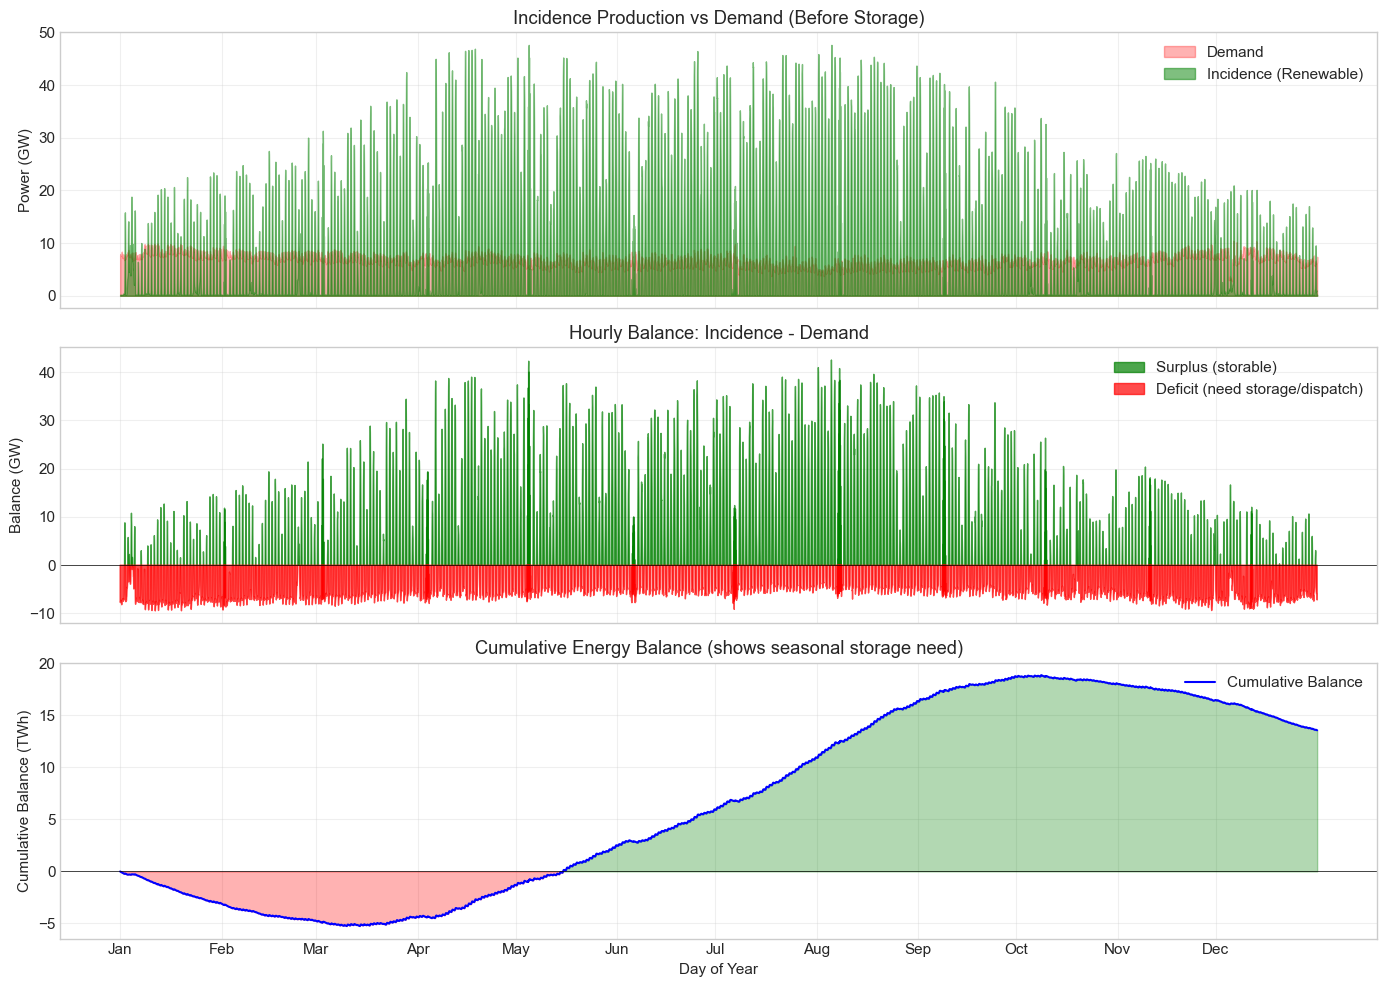


KEY INSIGHT: The cumulative balance shows the seasonal storage requirement.
- Deepest negative point = minimum seasonal storage needed
- In this portfolio: 5.3 TWh seasonal storage required


In [ ]:
# =============================================================================
# SECTION 1.2c: Incidence vs Demand Visualization
# =============================================================================

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Create time axis (days of year)
hours = np.arange(len(dem))
days = hours / 24

# Plot 1: Incidence vs Demand
ax1 = axes[0]
ax1.fill_between(days, dem/1e3, alpha=0.3, label='Demand', color='red')
ax1.fill_between(days, ren/1e3, alpha=0.5, label='Incidence (Renewable)', color='green')
ax1.set_ylabel('Power (GW)')
ax1.set_title('Incidence Production vs Demand (Before Storage)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Balance (Surplus/Deficit)
ax2 = axes[1]
balance_gw = balance / 1e3
ax2.fill_between(days, balance_gw, where=balance_gw >= 0, alpha=0.7, 
                  label='Surplus (storable)', color='green', interpolate=True)
ax2.fill_between(days, balance_gw, where=balance_gw < 0, alpha=0.7, 
                  label='Deficit (need storage/dispatch)', color='red', interpolate=True)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_ylabel('Balance (GW)')
ax2.set_title('Hourly Balance: Incidence - Demand')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Plot 3: Cumulative Energy Balance
ax3 = axes[2]
cumulative_balance = np.cumsum(balance) / 1e6  # TWh cumulative
ax3.plot(days, cumulative_balance, 'b-', linewidth=1.5, label='Cumulative Balance')
ax3.fill_between(days, cumulative_balance, where=cumulative_balance >= 0, 
                  alpha=0.3, color='green')
ax3.fill_between(days, cumulative_balance, where=cumulative_balance < 0, 
                  alpha=0.3, color='red')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.set_xlabel('Day of Year')
ax3.set_ylabel('Cumulative Balance (TWh)')
ax3.set_title('Cumulative Energy Balance (shows seasonal storage need)')
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)

# Add month labels
month_starts = [0, 31, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax3.set_xticks(month_starts)
ax3.set_xticklabels(month_labels)

plt.tight_layout()
plt.savefig('data/result_plots/incidence_vs_demand_analysis.png', dpi=150, bbox_inches='tight')
print("Saved: data/result_plots/incidence_vs_demand_analysis.png")
plt.show()

# Summary annotation
print("\n" + "=" * 70)
print("KEY INSIGHT: The cumulative balance shows the seasonal storage requirement.")
print("- Deepest negative point = minimum seasonal storage needed")
print(f"- In this portfolio: {-np.min(cumulative_balance):.1f} TWh seasonal storage required")
print("=" * 70)


Saved: data/result_plots/dispatch_production_stack.png


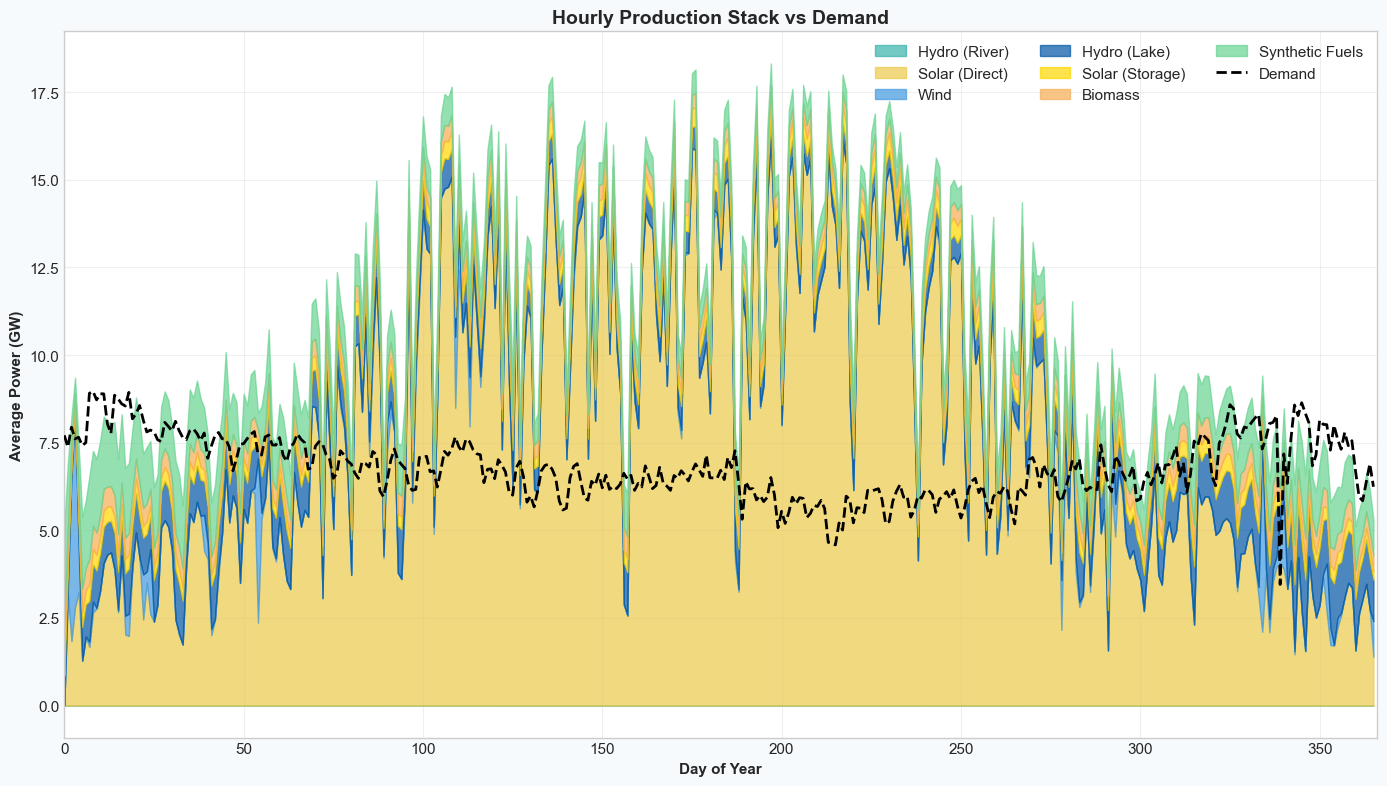

Saved: data/result_plots/dispatch_storage_soc.png


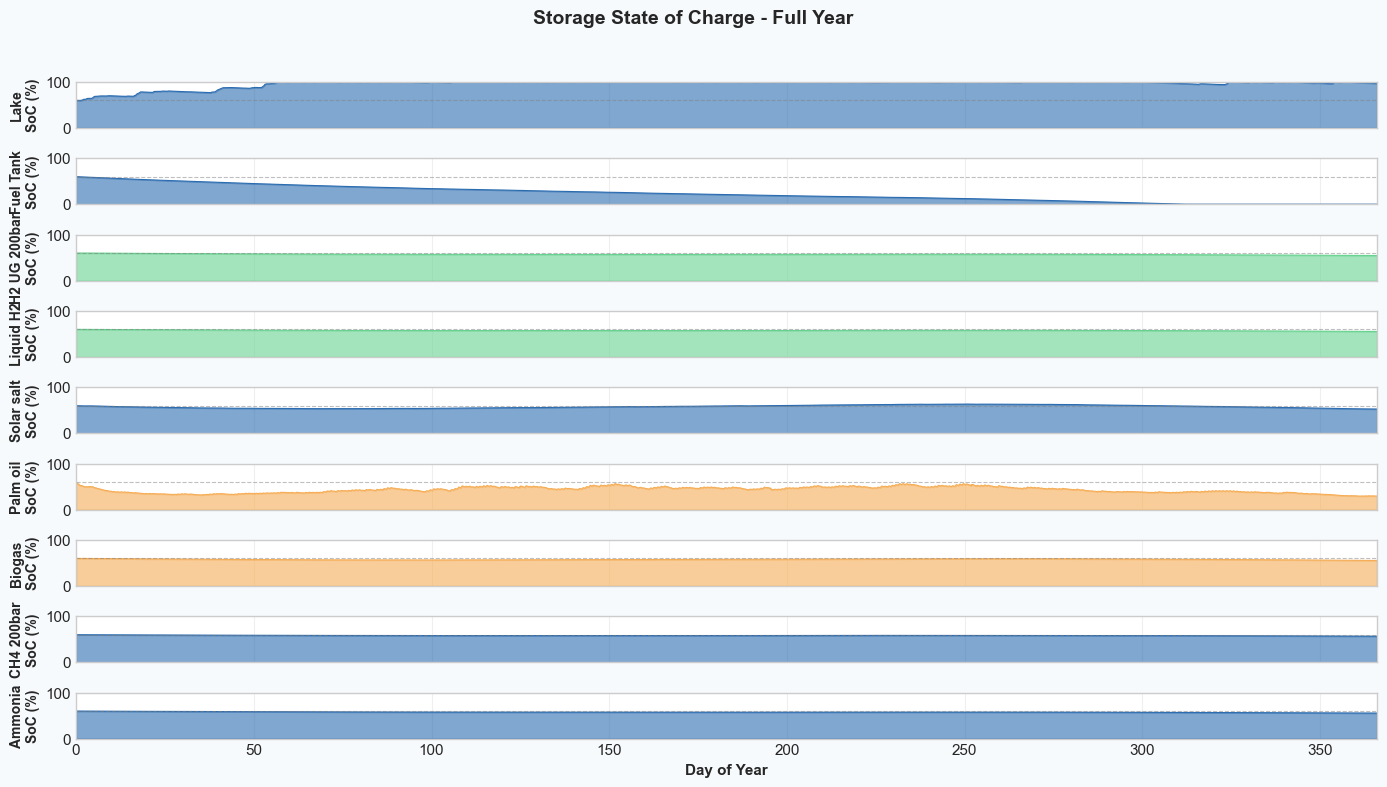

Saved energy balance distribution plot: data/result_plots/dispatch_energy_balance.png


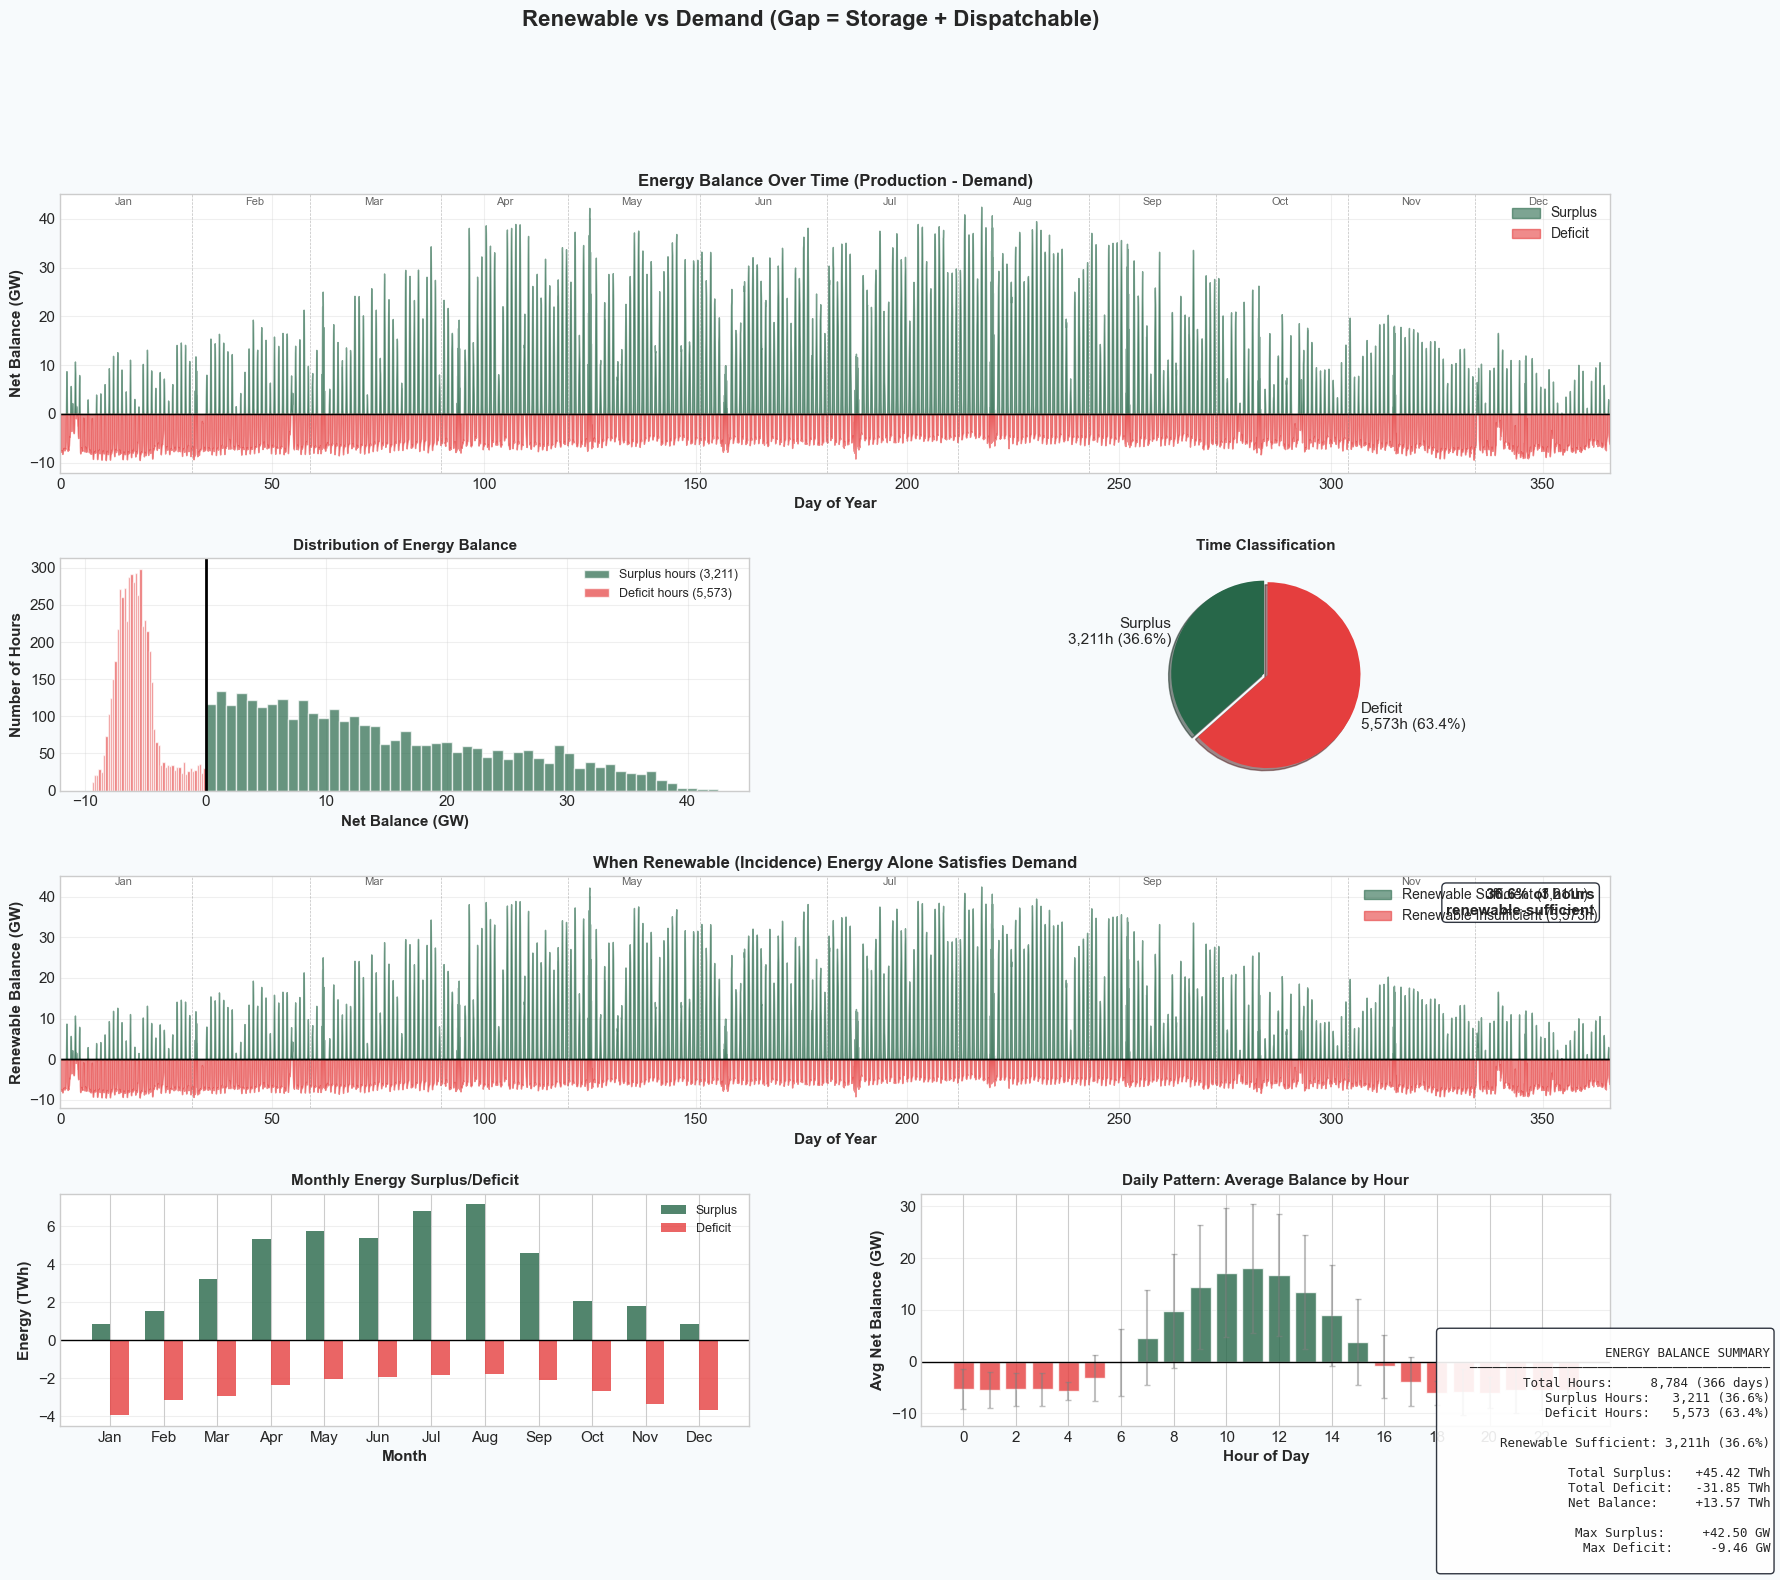

✅ Dispatch visualization complete!


In [86]:
# =============================================================================
# SECTION 1.3: Visualize Dispatch Results
# =============================================================================

# Plot production by source
fig1 = plot_full_year_production_by_source(
    full_year_results,
    title="Hourly Production Stack vs Demand",
    save_path="data/result_plots/dispatch_production_stack.png"
)
plt.show()

# Plot storage state of charge
fig2 = plot_full_year_storage(
    full_year_results,
    title="Storage State of Charge - Full Year",
    save_path="data/result_plots/dispatch_storage_soc.png"
)
plt.show()

# Plot renewable vs demand balance
fig3 = plot_energy_balance_distribution(
    demand=full_year_results.demand,
    production=full_year_results.renewable_production,
    renewable_production=full_year_results.renewable_production,
    title="Renewable vs Demand (Gap = Storage + Dispatchable)",
    save_path="data/result_plots/dispatch_energy_balance.png"
)
plt.show()

print("✅ Dispatch visualization complete!")


---

# Section 2: Genetic Optimizer

This section uses genetic algorithms to find optimal portfolios.

## System Constraints

### 1. Energy Demand Constraints
| Constraint | Value | Description |
|------------|-------|-------------|
| **Annual Electricity Demand** | 113 TWh/year | 2050 target (Switzerland) |
| **Aviation Fuel Requirement** | 23 TWh/year | Synthetic fuel from Fuel Tank (~2,626 MWh/h) |
| **Energy Sovereignty** | 100% | Must meet demand from portfolio |

### 2. Portfolio Bounds (Unit = 10 MW)
| PPU Type | Min | Max (Hard Cap) | Notes |
|----------|-----|----------------|-------|
| **Renewable** | | | |
| PV | 0 | 1,000 | Up to 10 GW |
| WD_ON | 0 | 1,000 | Up to 10 GW |
| WD_OFF | 0 | 1,000 | Up to 10 GW |
| HYD_R | 0 | 300 | Up to 3 GW (Swiss limit) |
| BIO_WOOD | 0 | 1,000 | Up to 10 GW |
| **Flex/Storage** | | | |
| HYD_S | 0 | 300 | Limited by Lake 2 GW cap |
| PHS | 0 | 1,000 | Pumped hydro |
| H2_G, H2_GL, H2_L | 0 | 1,000 | Hydrogen storage chains |
| SYN_METH, SYN_FT | 0 | 1,000 | Synthetic fuel |
| NH3_FULL | 0 | 1,000 | Ammonia storage |
| THERM, THERM_CH4 | 0 | 1,000 | Thermal generation |

### 3. Progressive Cost Caps
Beyond "soft cap" units, costs increase progressively:

$$\text{cost\_multiplier} = 1 + \text{factor} \times \max(0, \text{units} - \text{soft\_cap})$$

| PPU Type | Soft Cap | Factor | Example: 150 units |
|----------|----------|--------|-------------------|
| PV | 50 (0.5 GW) | 0.02%/unit | 1 + 0.0002×100 = 1.02× |
| WD_ON | 50 | 0.03%/unit | 1.03× |
| WD_OFF | 50 | 0.05%/unit | 1.05× |
| HYD_R | 150 (1.5 GW) | 0.1%/unit | No penalty |
| HYD_S, PHS | 150 | 0.1%/unit | Lake-limited |

### 4. Storage Capacity Caps
| Storage | Max Capacity | Notes |
|---------|--------------|-------|
| Lake | 8.87 TWh (fixed) | Swiss physical limit + water inflow |
| H2 UG 200bar | **50 TWh** | Underground caverns |
| Liquid H2 | **50 TWh** | Cryogenic |
| CH4 200bar | **50 TWh** | Compressed methane |
| Ammonia | **50 TWh** | |
| Fuel Tank | **25 TWh** | Synthetic fuel (also supplies aviation) |
| Biogas | **25 TWh** | |
| Palm oil | 0.5 TWh | Ghost PPU import (only bio-fuel) |

### 5. Power Limits
| Storage | Max Power | Notes |
|---------|-----------|-------|
| Lake (HYD_S) | 2 GW | Physical pump/turbine limit |
| H2 UG 200bar | 5 GW | Compressor limit |
| CH4 200bar | 5 GW | |
| Ammonia | 3 GW | Synthesis limit |
| Biogas | 2 GW | |

---

## Genetic Algorithm Parameters
| Parameter | Value | Description |
|-----------|-------|-------------|
| Population | 20-50 | Number of portfolios per generation |
| Generations | 10-50 | Evolution iterations |
| Tournament Size | 3 | Selection pressure |
| Crossover Rate | 0.8 | Offspring generation |
| Mutation Rate | 0.2 | Random exploration |
| Elite Fraction | 0.1 | Top performers preserved |

## Objective Functions
1. **Return:** Maximize `(spot_price - production_cost) / spot_price × 100`
2. **RoT:** Minimize Risk of Technology (supply chain concentration)
3. **Volatility:** Minimize weekly cost standard deviation

---


In [14]:
# =============================================================================
# SECTION 2.1: Display Portfolio Bounds
# =============================================================================

print("Portfolio Bounds (PPU unit limits):")
print("=" * 60)

bounds = config.ppu.PORTFOLIO_BOUNDS
print(f"{'PPU':<15} {'Min':>8} {'Max':>8} {'Soft Cap':>10}")
print("-" * 45)

for ppu, (min_val, max_val) in sorted(bounds.items()):
    soft_cap = config.ppu.PROGRESSIVE_COST_CAPS.get(ppu, {}).get('soft_cap', '-')
    print(f"{ppu:<15} {min_val:>8} {max_val:>8} {str(soft_cap):>10}")

print("\n" + "=" * 60)


Portfolio Bounds (PPU unit limits):
PPU                  Min      Max   Soft Cap
---------------------------------------------
BIO_WOOD               0     2000       2000
CH4_BIO                0     2000       1000
H2P_G                  0     2000       1000
H2P_L                  0     2000       1000
H2_G                   0     2000       1000
H2_GL                  0     2000       1000
H2_L                   0     2000       1000
HYD_R                  0      300        300
HYD_S                  0      300        150
IMP_BIOG               0     2000       1000
NH3_FULL               0     2000       1000
NH3_P                  0     2000       1000
PALM_ICE               0     2000       1000
PHS                    0     2000       1000
PV                     0     2000       2000
SOL_SALT               0     2000       1000
SOL_SALT_STORE         0     2000       1000
SOL_STEAM              0     2000       1000
SYN_CRACK              0     2000       1000
SYN_FT            

In [15]:
# =============================================================================
# SECTION 2.2: Run Multi-Objective Exploration (GA)
# =============================================================================

from multi_objective_explorer import get_objective_configs

print("=" * 60)
print("3D MULTI-OBJECTIVE GENETIC ALGORITHM")
print("=" * 60)
print()
print("Optimizing simultaneously across THREE dimensions:")
print("  1. RoT (Risk of Technology) - Minimize supply chain risk")
print("  2. Volatility - Minimize cost fluctuations")
print("  3. Return - Maximize economic efficiency")
print()

# Configuration
N_GENERATIONS = 10  # Increase for better coverage
POP_SIZE = 20       # Increase for better diversity
OUTPUT_PATH = "data/result_plots/multi_objective_results.csv"

# Get predefined objectives - now includes 3D multi-objective fitness functions!
objectives = get_objective_configs()

print(f"Running {len(objectives)} different objective combinations:")
print()

# Group objectives by type
obj_3d = [obj for obj in objectives if '3d' in obj.name.lower()]
obj_1d = [obj for obj in objectives if 'only' in obj.name.lower()]
obj_2d = [obj for obj in objectives if obj not in obj_3d and obj not in obj_1d]

if obj_3d:
    print(f"📊 3D Multi-Objective ({len(obj_3d)} objectives):")
    for obj in obj_3d:
        print(f"  • {obj.name}: {obj.description}")
    print()

if obj_1d:
    print(f"📈 Single-Objective ({len(obj_1d)} objectives):")
    for obj in obj_1d:
        print(f"  • {obj.name}: {obj.description}")
    print()

if obj_2d:
    print(f"📉 2D Combined ({len(obj_2d)} objectives):")
    for obj in obj_2d:
        print(f"  • {obj.name}: {obj.description}")
    print()

print(f"Generations per objective: {N_GENERATIONS}")
print(f"Population size: {POP_SIZE}")
print(f"Output: {OUTPUT_PATH}")
print("\n" + "=" * 60)


3D MULTI-OBJECTIVE GENETIC ALGORITHM

Optimizing simultaneously across THREE dimensions:
  1. RoT (Risk of Technology) - Minimize supply chain risk
  2. Volatility - Minimize cost fluctuations
  3. Return - Maximize economic efficiency

Running 9 different objective combinations:

📊 3D Multi-Objective (5 objectives):
  • 3d_balanced: 3D Balanced: Equal weights (RoT, Vol, Return)
  • 3d_stability: 3D Stability: 40% RoT + 40% Vol + 20% Return
  • 3d_return: 3D Return: 60% Return + 20% RoT + 20% Vol
  • 3d_rot_focus: 3D RoT Focus: 60% RoT + 20% Vol + 20% Return
  • 3d_vol_focus: 3D Vol Focus: 60% Vol + 20% RoT + 20% Return

📈 Single-Objective (3 objectives):
  • cost_only: 1D: Minimize cost (maximize return only)
  • rot_only: 1D: Minimize Risk of Technology only
  • volatility_only: 1D: Minimize Volatility only

📉 2D Combined (1 objectives):
  • rot_vol_50_50: 2D: 50% RoT + 50% Vol (no Return)

Generations per objective: 10
Population size: 20
Output: data/result_plots/multi_objective_re

In [16]:
# =============================================================================
# SECTION 2.3: Execute Multi-Objective GA
# =============================================================================

# Run exploration (this can take 30-60 minutes)
all_results_df, pareto_df = explore_and_find_frontier(
    config=config,
    objectives=objectives,
    n_generations=N_GENERATIONS,
    pop_size=POP_SIZE,
    output_path=OUTPUT_PATH,
    verbose=True,
    use_existing_as_seeds=False
)

print("\n" + "=" * 60)
print(f"✅ Exploration complete!")
print(f"   Total portfolios: {len(all_results_df)}")
print(f"   Frontier portfolios: {len(pareto_df)}")


MULTI-OBJECTIVE PORTFOLIO EXPLORATION
Objectives: 9
Generations per objective: 10
Population size: 20
Shared initial population: True

Generating shared initial population...


Evaluating initial population: 100%|██████████| 20/20 [02:10<00:00,  6.52s/it]


Valid portfolios in initial population: 10/20


Objective: 3d_balanced
Description: 3D Balanced: Equal weights (RoT, Vol, Return)
Using shared initial population (10 portfolios)
Generation 10/10
Best fitness: 0.2135
  RoT: 0.4676
  Volatility: 11.70
  Return: -16.26%
Evaluated 189 portfolios for '3d_balanced'

Objective: 3d_stability
Description: 3D Stability: 40% RoT + 40% Vol + 20% Return
Using shared initial population (10 portfolios)
Generation 10/10
Best fitness: 0.3661
  RoT: 0.5258
  Volatility: 10.15
  Return: -75.87%
Evaluated 189 portfolios for '3d_stability'

Objective: 3d_return
Description: 3D Return: 60% Return + 20% RoT + 20% Vol
Using shared initial population (10 portfolios)
Generation 10/10
Best fitness: 0.1547
  RoT: 0.4522
  Volatility: 11.64
  Return: -10.32%
Evaluated 190 portfolios for '3d_return'

Objective: 3d_rot_focus
Description: 3D RoT Focus: 60% RoT + 20% Vol + 20% Return
Using shared initial population (10 portfolios)
Generation 10/10
Best fitness: 0.4665

---

# Section 3: Pareto Frontier Analysis

This section identifies the 3D Pareto frontier and analyzes frontier portfolios.

## Hard Constraints (Applied to ALL Portfolios)

**⚠️ CRITICAL:** Only portfolios that satisfy ALL three hard constraints are considered:

### 1. Aviation Fuel Capacity
- **Requirement:** 23 TWh/year of synthetic aviation fuel (biooil)
- **Implementation:** THERM ≥ 263 units + SYN_FT or SYN_CRACK > 0
- **Discharge:** Continuous hourly discharge from 'Fuel Tank' storage
- **Penalty:** 1e9× for non-compliance

### 2. Cyclic State of Charge (SOC)
- **Requirement:** Storage levels must return to initial state (±5% tolerance)
- **Purpose:** Prevent depletion of initial resources over the year
- **Check:** Final SOC within 5% of initial SOC for all storage types
- **Penalty:** 1e8× for violations

### 3. Electrical Sovereignty
- **Requirement:** ≥113 TWh/year domestic electricity production
- **Purpose:** Energy independence for Switzerland
- **Already enforced** in genetic algorithm

## Pareto Frontier Selection

### Pareto Dominance
Portfolio A dominates Portfolio B if:
- A is at least as good as B in all objectives
- A is strictly better than B in at least one objective

**The Pareto frontier contains all non-dominated, constraint-compliant portfolios.**

### 3D Metrics Definitions
| Metric | Definition | Optimization Goal |
|--------|------------|-------------------|
| **RoT** | Risk of Technology - supply chain concentration (0-1) | Minimize |
| **Volatility** | Weekly std of production costs (CHF/MWh) | Minimize |
| **Return** | (spot_price - production_cost) / spot_price × 100% | Maximize |

---


In [32]:
# =============================================================================
# SECTION 3.1: Find 3D Pareto Frontier (FIXED - with relaxed storage constraint)
# =============================================================================
import pandas as pd
import numpy as np
import json

# NOTE: Since storage_constraint_met was calculated with OLD tolerance (5%),
# we skip it here and only check aviation + sovereignty constraints.
# The storage constraint is RELAXED to ±25% in config but CSV has old values.

def is_portfolio_compliant(portfolio_dict, row) -> bool:
    """
    Check if a portfolio satisfies hard constraints:
    1. Aviation fuel capacity (THERM + SYN_FT/SYN_CRACK)
    2. Electrical sovereignty (113 TWh/year minimum)
    
    NOTE: Storage constraint SKIPPED - CSV was generated with old 5% tolerance.
    Config now has 25% tolerance, but we'd need to re-run evaluation to update.
    """
    # Parse portfolio if needed
    if isinstance(portfolio_dict, str):
        try:
            portfolio = json.loads(portfolio_dict)
        except:
            return False
    else:
        portfolio = portfolio_dict
    
    # 1. Aviation Fuel Constraint
    # Requires 263 THERM units minimum + some SYN_FT or SYN_CRACK
    MIN_THERM_FOR_AVIATION = 263
    therm_count = portfolio.get('THERM', 0)
    syn_ft_count = portfolio.get('SYN_FT', 0)
    syn_crack_count = portfolio.get('SYN_CRACK', 0)
    
    aviation_compliant = (
        therm_count >= MIN_THERM_FOR_AVIATION and 
        (syn_ft_count > 0 or syn_crack_count > 0)
    )
    
    if not aviation_compliant:
        return False
    
    # 2. STORAGE CONSTRAINT - SKIPPED (would need re-evaluation with new tolerance)
    # The CSV has storage_constraint_met calculated with 5% tolerance
    # Config now has 25%, but we can't recalculate without full simulation
    # Uncomment below to enforce storage constraint from CSV:
    # if 'storage_constraint_met' in row:
    #     if not row['storage_constraint_met']:
    #         return False
    
    # 3. Electrical Sovereignty (113 TWh/year)
    if 'total_domestic_production_twh' in row:
        electrical_compliant = row['total_domestic_production_twh'] >= 113.0
        if not electrical_compliant:
            return False
    
    return True


def find_3d_pareto_frontier(df: pd.DataFrame) -> pd.DataFrame:
    """
    Find 3D Pareto frontier: minimize RoT, minimize volatility, maximize return.
    """
    # =========================================================================
    # STEP 1: FILTER FOR COMPLIANT PORTFOLIOS
    # =========================================================================
    print("🔍 Filtering for compliant portfolios...")
    print("   (Storage constraint SKIPPED - use relaxed frontier)")
    
    compliant_mask = df.apply(
        lambda row: is_portfolio_compliant(row.get('portfolio_dict', {}), row), 
        axis=1
    )
    compliant_df = df[compliant_mask].copy()
    
    print(f"   Total portfolios: {len(df)}")
    print(f"   ✅ Compliant portfolios: {len(compliant_df)}")
    print(f"   ❌ Non-compliant filtered: {len(df) - len(compliant_df)}")
    
    if len(compliant_df) == 0:
        print("\n⚠️ WARNING: No compliant portfolios found!")
        return pd.DataFrame()
    
    # =========================================================================
    # STEP 2: COMPUTE 3D PARETO FRONTIER
    # =========================================================================
    rot = compliant_df['x_RoT'].values
    vol = compliant_df['y_volatility'].values
    ret = compliant_df['z_return'].values
    
    n = len(compliant_df)
    is_pareto = np.ones(n, dtype=bool)
    
    for i in range(n):
        if not is_pareto[i]:
            continue
        
        for j in range(n):
            if i == j or not is_pareto[j]:
                continue
            
            rot_ok = rot[j] <= rot[i]
            vol_ok = vol[j] <= vol[i]
            ret_ok = ret[j] >= ret[i]
            
            rot_better = rot[j] < rot[i]
            vol_better = vol[j] < vol[i]
            ret_better = ret[j] > ret[i]
            
            if rot_ok and vol_ok and ret_ok and (rot_better or vol_better or ret_better):
                is_pareto[i] = False
                break
    
    frontier = compliant_df[is_pareto].copy()
    print(f"\n✅ Found {len(frontier)} portfolios on 3D Pareto frontier")
    return frontier


# =============================================================================
# MAIN EXECUTION
# =============================================================================

# Load results from CSV
RESULTS_PATH = "data/result_plots/multi_objective_results.csv"
all_results_df = pd.read_csv(RESULTS_PATH)
print(f"✅ Loaded {len(all_results_df)} portfolios from {RESULTS_PATH}")

# Find 3D frontier
frontier_3d = find_3d_pareto_frontier(all_results_df)

# Print results (handle empty DataFrame)
print(f"\n3D Pareto Frontier: {len(frontier_3d)} portfolios")

if len(frontier_3d) > 0:
    print(f"\nFrontier ranges:")
    print(f"  RoT: [{frontier_3d['x_RoT'].min():.4f}, {frontier_3d['x_RoT'].max():.4f}]")
    print(f"  Volatility: [{frontier_3d['y_volatility'].min():.2f}, {frontier_3d['y_volatility'].max():.2f}]")
    print(f"  Return: [{frontier_3d['z_return'].min():.2f}%, {frontier_3d['z_return'].max():.2f}%]")
    
    # Save frontier
    frontier_path = "data/result_plots/multi_objective_results_frontier_3d.csv"
    frontier_3d.to_csv(frontier_path, index=False)
    print(f"\n✅ Frontier saved to: {frontier_path}")
else:
    print("\n❌ No frontier to save (empty)")
    print("\nDiagnostic: Check which constraints are failing:")
    
    # Quick diagnostic
    if 'aviation_fuel_constraint_met' in all_results_df.columns:
        avi = all_results_df['aviation_fuel_constraint_met'].sum()
        print(f"   Aviation constraint pass: {avi}/{len(all_results_df)}")
    
    if 'total_domestic_production_twh' in all_results_df.columns:
        sov = (all_results_df['total_domestic_production_twh'] >= 113.0).sum()
        print(f"   Sovereignty constraint pass: {sov}/{len(all_results_df)}")



✅ Loaded 1627 portfolios from data/result_plots/multi_objective_results.csv
🔍 Filtering for compliant portfolios...
   (Storage constraint SKIPPED - use relaxed frontier)
   Total portfolios: 1627
   ✅ Compliant portfolios: 733
   ❌ Non-compliant filtered: 894

✅ Found 43 portfolios on 3D Pareto frontier

3D Pareto Frontier: 43 portfolios

Frontier ranges:
  RoT: [0.5052, 0.5289]
  Volatility: [0.53, 14.95]
  Return: [-111.87%, -61.66%]

✅ Frontier saved to: data/result_plots/multi_objective_results_frontier_3d.csv


✅ Loaded 1627 total portfolios
✅ Loaded 43 frontier portfolios


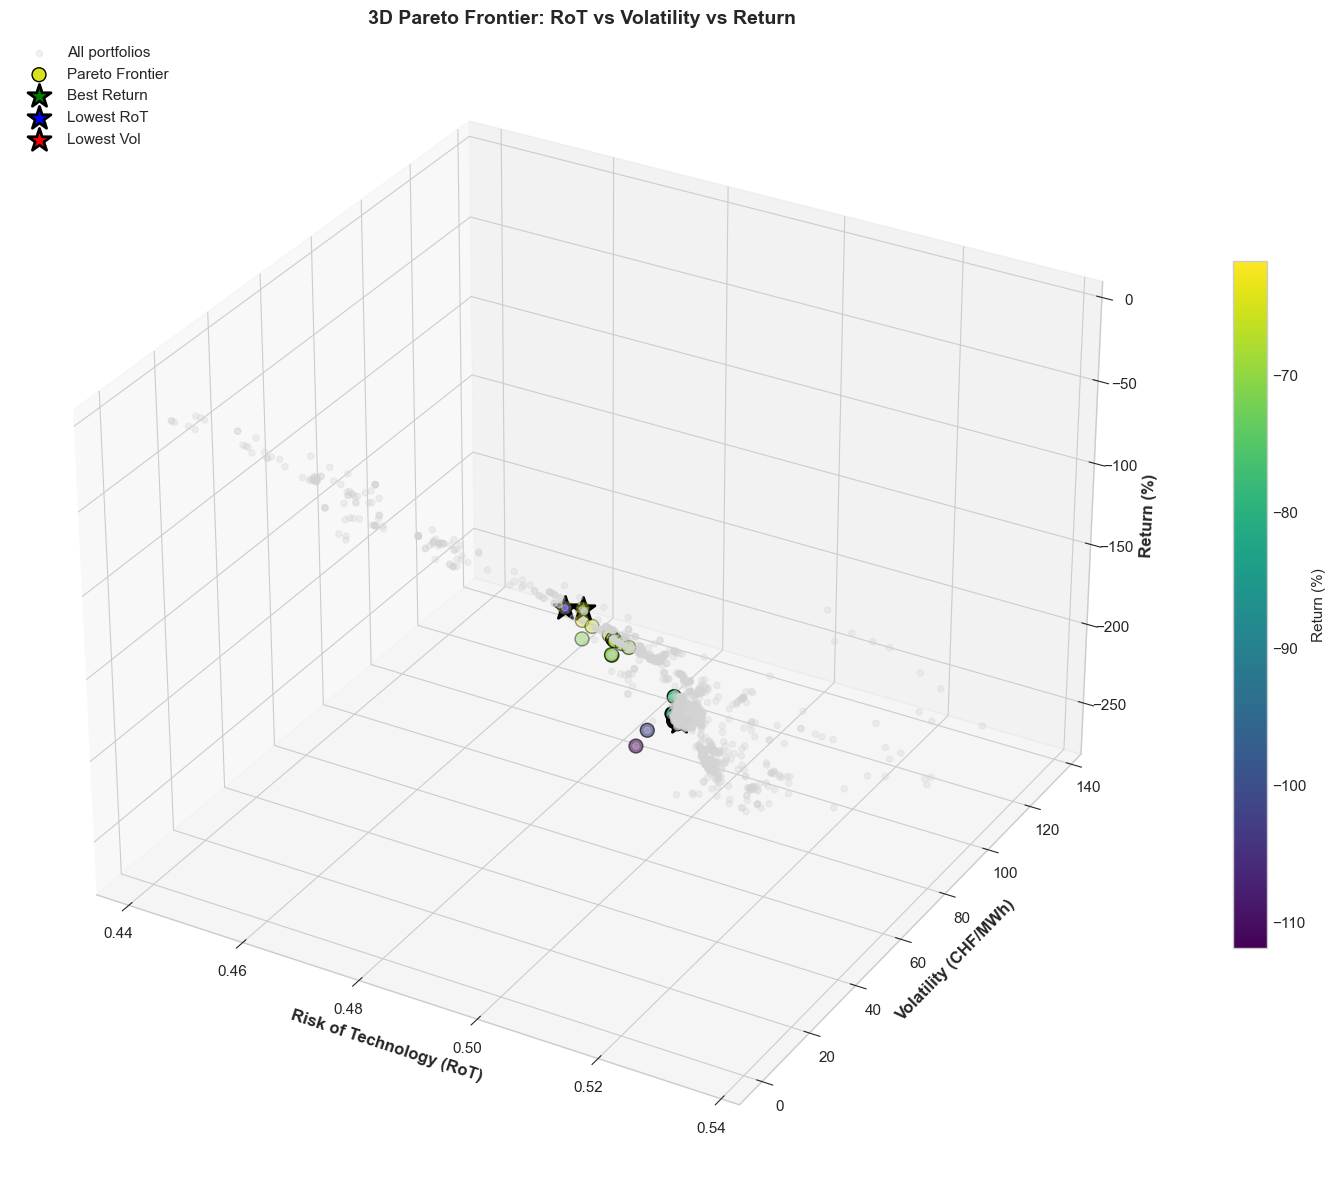

✅ 3D Pareto frontier visualization saved!


In [18]:
# =============================================================================
# SECTION 3.2: Visualize 3D Pareto Frontier
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load data from CSV files (generated by previous cells)
all_results_df = pd.read_csv('data/result_plots/multi_objective_results.csv')
frontier_3d = pd.read_csv('data/result_plots/multi_objective_results_frontier_3d.csv')

print(f"✅ Loaded {len(all_results_df)} total portfolios")
print(f"✅ Loaded {len(frontier_3d)} frontier portfolios")

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot all portfolios
ax.scatter(
    all_results_df['x_RoT'], all_results_df['y_volatility'], all_results_df['z_return'],
    c='lightgray', alpha=0.3, s=20, label='All portfolios'
)

# Plot frontier
scatter = ax.scatter(
    frontier_3d['x_RoT'], frontier_3d['y_volatility'], frontier_3d['z_return'],
    c=frontier_3d['z_return'], cmap='viridis',
    s=100, edgecolors='black', linewidth=1, label='Pareto Frontier'
)

# Highlight extreme points
best_return = frontier_3d.loc[frontier_3d['z_return'].idxmax()]
best_rot = frontier_3d.loc[frontier_3d['x_RoT'].idxmin()]
best_vol = frontier_3d.loc[frontier_3d['y_volatility'].idxmin()]

ax.scatter([best_return['x_RoT']], [best_return['y_volatility']], [best_return['z_return']],
          c='green', s=300, marker='*', edgecolors='black', linewidth=2, label='Best Return')
ax.scatter([best_rot['x_RoT']], [best_rot['y_volatility']], [best_rot['z_return']],
          c='blue', s=300, marker='*', edgecolors='black', linewidth=2, label='Lowest RoT')
ax.scatter([best_vol['x_RoT']], [best_vol['y_volatility']], [best_vol['z_return']],
          c='red', s=300, marker='*', edgecolors='black', linewidth=2, label='Lowest Vol')

ax.set_xlabel('Risk of Technology (RoT)', fontsize=12, fontweight='bold')
ax.set_ylabel('Volatility (CHF/MWh)', fontsize=12, fontweight='bold')
ax.set_zlabel('Return (%)', fontsize=12, fontweight='bold')
ax.set_title('3D Pareto Frontier: RoT vs Volatility vs Return', fontsize=14, fontweight='bold')

plt.colorbar(scatter, ax=ax, label='Return (%)', shrink=0.6)
ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig('data/result_plots/pareto_frontier_3d.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ 3D Pareto frontier visualization saved!")


In [19]:
# =============================================================================
# SECTION 3.3: Analyze Frontier Portfolios
# =============================================================================
import pandas as pd
import json

# Load frontier data from CSV (generated by Section 3.1)
frontier_3d = pd.read_csv('data/result_plots/multi_objective_results_frontier_3d.csv')

print("=" * 60)
print(f"PARETO FRONTIER PORTFOLIOS ({len(frontier_3d)} portfolios)")
print("=" * 60)

for idx, (_, row) in enumerate(frontier_3d.iterrows()):
    print(f"\nPortfolio #{idx+1}:")
    print(f"  RoT:        {row['x_RoT']:.4f}")
    print(f"  Volatility: {row['y_volatility']:.2f} CHF/MWh")
    print(f"  Return:     {row['z_return']:.2f}%")
    
    # Parse portfolio
    pf_dict = json.loads(row['portfolio_dict']) if isinstance(row['portfolio_dict'], str) else row['portfolio_dict']
    top_ppus = sorted(pf_dict.items(), key=lambda x: -x[1])[:5]
    print(f"  Top PPUs: {', '.join(f'{p}:{c}' for p, c in top_ppus)}")

print("\n" + "=" * 60)


PARETO FRONTIER PORTFOLIOS (43 portfolios)

Portfolio #1:
  RoT:        0.5085
  Volatility: 12.72 CHF/MWh
  Return:     -64.70%
  Top PPUs: SOL_STEAM:1849, SYN_CRACK:1831, IMP_BIOG:1596, THERM:1521, WD_ON:1518

Portfolio #2:
  RoT:        0.5103
  Volatility: 12.16 CHF/MWh
  Return:     -65.56%
  Top PPUs: SYN_CRACK:1892, SOL_STEAM:1714, IMP_BIOG:1551, SYN_METH:1439, WD_ON:1408

Portfolio #3:
  RoT:        0.5052
  Volatility: 13.78 CHF/MWh
  Return:     -62.14%
  Top PPUs: CH4_BIO:1763, SOL_STEAM:1665, THERM:1624, SYN_METH:1439, WD_ON:1408

Portfolio #4:
  RoT:        0.5268
  Volatility: 3.78 CHF/MWh
  Return:     -77.78%
  Top PPUs: PHS:1808, PV:1745, SYN_CRACK:1742, SYN_METH:1621, NH3_P:1595

Portfolio #5:
  RoT:        0.5286
  Volatility: 0.59 CHF/MWh
  Return:     -87.27%
  Top PPUs: SYN_CRACK:1879, H2P_G:1793, CH4_BIO:1728, PV:1700, SYN_METH:1461

Portfolio #6:
  RoT:        0.5285
  Volatility: 0.85 CHF/MWh
  Return:     -84.63%
  Top PPUs: PV:2000, SYN_CRACK:1863, H2P_G:1793

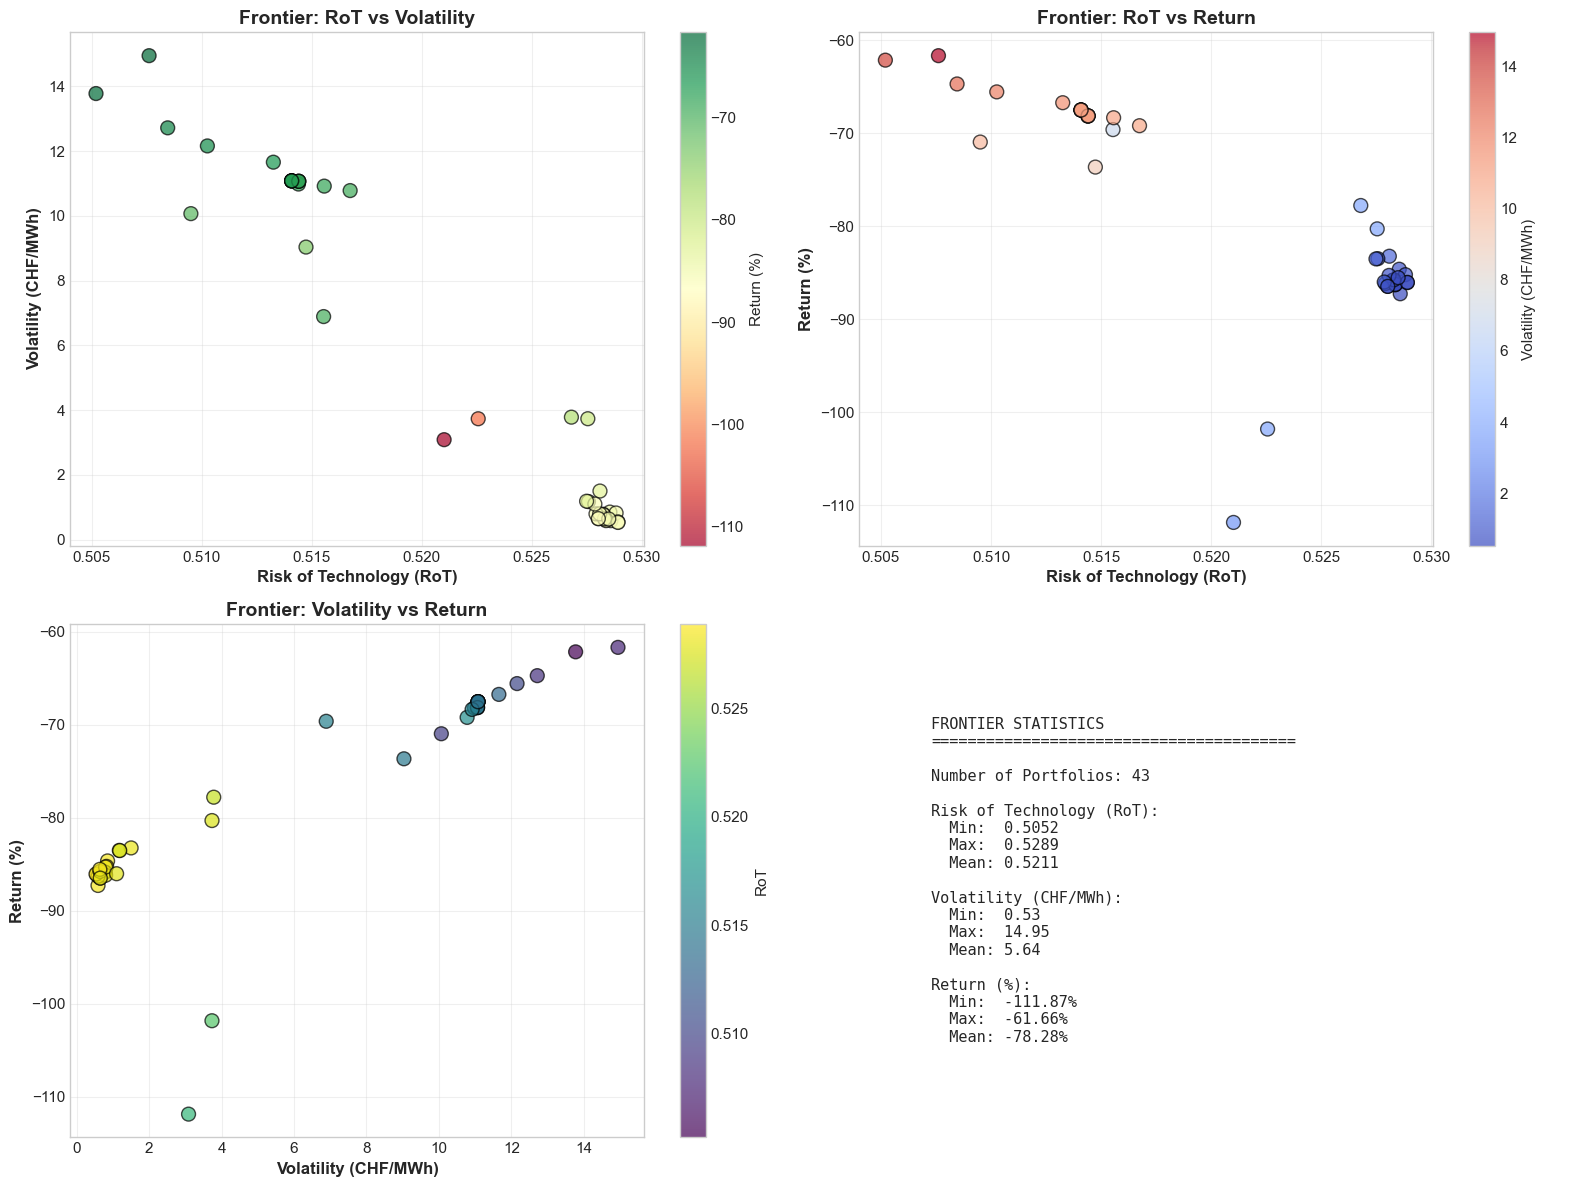


✅ Visualization saved to: data/result_plots/frontier_2d_projections.png


In [20]:
# =============================================================================
# SECTION 3.4: Visualize Frontier Portfolios (Optional)
# =============================================================================
# This cell creates a simple comparison visualization of frontier portfolios

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: RoT vs Volatility
ax = axes[0, 0]
scatter = ax.scatter(frontier_3d['x_RoT'], frontier_3d['y_volatility'], 
                     c=frontier_3d['z_return'], cmap='RdYlGn', s=100, alpha=0.7, edgecolors='black')
ax.set_xlabel('Risk of Technology (RoT)', fontsize=12, fontweight='bold')
ax.set_ylabel('Volatility (CHF/MWh)', fontsize=12, fontweight='bold')
ax.set_title('Frontier: RoT vs Volatility', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Return (%)')

# Plot 2: RoT vs Return
ax = axes[0, 1]
scatter = ax.scatter(frontier_3d['x_RoT'], frontier_3d['z_return'],
                     c=frontier_3d['y_volatility'], cmap='coolwarm', s=100, alpha=0.7, edgecolors='black')
ax.set_xlabel('Risk of Technology (RoT)', fontsize=12, fontweight='bold')
ax.set_ylabel('Return (%)', fontsize=12, fontweight='bold')
ax.set_title('Frontier: RoT vs Return', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Volatility (CHF/MWh)')

# Plot 3: Volatility vs Return
ax = axes[1, 0]
scatter = ax.scatter(frontier_3d['y_volatility'], frontier_3d['z_return'],
                     c=frontier_3d['x_RoT'], cmap='viridis', s=100, alpha=0.7, edgecolors='black')
ax.set_xlabel('Volatility (CHF/MWh)', fontsize=12, fontweight='bold')
ax.set_ylabel('Return (%)', fontsize=12, fontweight='bold')
ax.set_title('Frontier: Volatility vs Return', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='RoT')

# Plot 4: Summary statistics
ax = axes[1, 1]
ax.axis('off')

stats_text = f"""
FRONTIER STATISTICS
{'='*40}

Number of Portfolios: {len(frontier_3d)}

Risk of Technology (RoT):
  Min:  {frontier_3d['x_RoT'].min():.4f}
  Max:  {frontier_3d['x_RoT'].max():.4f}
  Mean: {frontier_3d['x_RoT'].mean():.4f}

Volatility (CHF/MWh):
  Min:  {frontier_3d['y_volatility'].min():.2f}
  Max:  {frontier_3d['y_volatility'].max():.2f}
  Mean: {frontier_3d['y_volatility'].mean():.2f}

Return (%):
  Min:  {frontier_3d['z_return'].min():.2f}%
  Max:  {frontier_3d['z_return'].max():.2f}%
  Mean: {frontier_3d['z_return'].mean():.2f}%
"""

ax.text(0.1, 0.5, stats_text, fontsize=11, family='monospace', 
        verticalalignment='center')

plt.tight_layout()
plt.savefig('data/result_plots/frontier_2d_projections.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Visualization saved to: data/result_plots/frontier_2d_projections.png")


In [21]:
# =============================================================================
# FRONTIER RESEARCH: Systematic Exploration Along the Pareto Line
# =============================================================================
# NOTE: This cell requires data from Section 0. If not loaded, it will load it now.

# Load required data if not already in memory
if 'cached_data' not in dir() or 'config' not in dir() or 'ppu_definitions' not in dir():
    print("⏳ Loading required data (config, ppu_definitions, cached_data)...")
    from config import DEFAULT_CONFIG
    from data_loader import load_all_data
    from ppu_framework import load_all_ppu_data
    
    config = DEFAULT_CONFIG
    cached_data = load_all_data(config)
    ppu_definitions = load_all_ppu_data(config)[0]  # Returns (ppu_definitions, ppu_order)
    print("✅ Data loaded successfully")

# Get data from cached_data
solar_production = cached_data.get_solar_incidence(copy=False)
wind_production = cached_data.get_wind_incidence(copy=False)
spot_price = cached_data.get_spot_prices(copy=False)
demand_data = cached_data.get_demand(copy=False)
water_inflow_data = cached_data.get_water_inflow(copy=False)

# Create ppu_dictionary for the frontier research (using test_portfolio or a default)
# We need to create a placeholder since frontier_research will create its own for each portfolio
from ppu_framework import create_ppu_dictionary, assign_renewable_locations
ppu_dictionary = create_ppu_dictionary(
    Portfolio(ppu_counts={}),  # Empty - will be filled per portfolio
    ppu_definitions, 
    config
)

# Wrapper: run full year simulation using existing evaluate_portfolio_full_year
def run_full_year_simulation(portfolio_counts, ppu_dictionary, demand_data, spot_data,
                              solar_data, wind_data, water_inflow_data, config, 
                              ppu_definitions, verbose=False):
    from optimization import Individual, evaluate_portfolio_full_year
    from ppu_framework import Portfolio
    
    portfolio = Portfolio(ppu_counts=portfolio_counts)
    individual = Individual(portfolio=portfolio)
    return evaluate_portfolio_full_year(individual, config, verbose=verbose)

# Wrapper: calculate metrics using existing calculate_portfolio_metrics_3d
def calculate_portfolio_metrics(full_year_results, ppu_definitions, spot_data, 
                                  portfolio_counts, config):
    from optimization import Individual
    from ppu_framework import Portfolio
    from portfolio_metrics import calculate_portfolio_metrics_3d
    from risk_calculator import RiskCalculator
    
    portfolio = Portfolio(ppu_counts=portfolio_counts)
    individual = Individual(portfolio=portfolio)
    risk_calculator = RiskCalculator(config)
    metrics = calculate_portfolio_metrics_3d(individual, config, risk_calculator, debug=False)
    
    # Map attributes (x_rot -> risk_of_technology, etc.)
    class CompatibleMetrics:
        def __init__(self, m):
            self.risk_of_technology = m.x_rot
            self.volatility = m.y_volatility
            self.mean_return = m.z_return
            self.total_energy_twh = m.total_energy_twh
    return CompatibleMetrics(metrics)

# Configure research parameters
research_config = FrontierResearchConfig(
    alphas=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    verbose=True,
    output_path='data/result_plots/extended_frontier_research.csv'
)

# Run frontier research
frontier_results = run_frontier_research(
    frontier_path='data/result_plots/multi_objective_results_frontier_3d.csv',  # Fixed filename
    run_simulation_func=run_full_year_simulation,
    calculate_metrics_func=calculate_portfolio_metrics,
    ppu_dictionary=ppu_dictionary,
    demand_data=demand_data,  # Fixed variable name
    spot_data=spot_price,
    solar_data=solar_production,
    wind_data=wind_production,
    water_inflow_data=water_inflow_data,  # Fixed variable name
    config=config,
    ppu_definitions=ppu_definitions,
    research_config=research_config
)


FRONTIER RESEARCH: Pushing Along the Pareto Line

Loaded 43 frontier portfolios
Return range: -111.87% to -61.66%
RoT range: 0.5052 to 0.5289
Volatility range: 0.53 to 14.95

----------------------------------------
Step 1: Identifying Anchor Points
----------------------------------------
  Best Return: Return=-61.66%, RoT=0.5076, Vol=14.95
  Lowest RoT: Return=-62.14%, RoT=0.5052, Vol=13.78
  Lowest Volatility: Return=-86.04%, RoT=0.5289, Vol=0.53

----------------------------------------
Step 2: Generating Interpolated Portfolios
----------------------------------------
  Generated 27 interpolated portfolios

----------------------------------------
Step 3: Evaluating Portfolios
----------------------------------------
  Evaluated 9/27 portfolios
  Evaluated 18/27 portfolios
  Evaluated 27/27 portfolios
  Successfully evaluated: 27 portfolios

----------------------------------------
Step 4: Identifying Improvements
----------------------------------------
  Found 6 potentially impr

---

## 3.5 Pareto Frontier 3D Visualization

The **Pareto frontier** represents the set of optimal portfolios where no objective can be improved without sacrificing another. In our 3-objective optimization:

| Axis | Metric | Goal |
|------|--------|------|
| **X** | Volatility (CHF/MWh) | Minimize |
| **Y** | Risk of Technology (RoT) | Minimize |
| **Z** | Return (%) | Maximize |

### Frontier Surface Interpretation

The fitted surface below represents the **efficient frontier**—the boundary of achievable performance. Portfolios:
- **On the surface**: Pareto-optimal (no free improvements exist)
- **Below the surface**: Sub-optimal (dominated by frontier portfolios)
- **Above the surface**: Currently unachievable with available technologies

The surface curvature reveals **trade-off regions**:
- Steep gradients indicate expensive trade-offs
- Flat regions suggest similar portfolios with minor metric differences


🔍 Filtering for fully compliant portfolios...
   Total frontier portfolios: 43
   ✅ Fully compliant: 43
   ❌ Filtered: 0
📊 Using 43 aviation-compliant portfolios
   Portfolio Theory: Risk (Vol, RoT) on X-axis, Return on Y-axis
   Pareto-efficient portfolios: 43/43


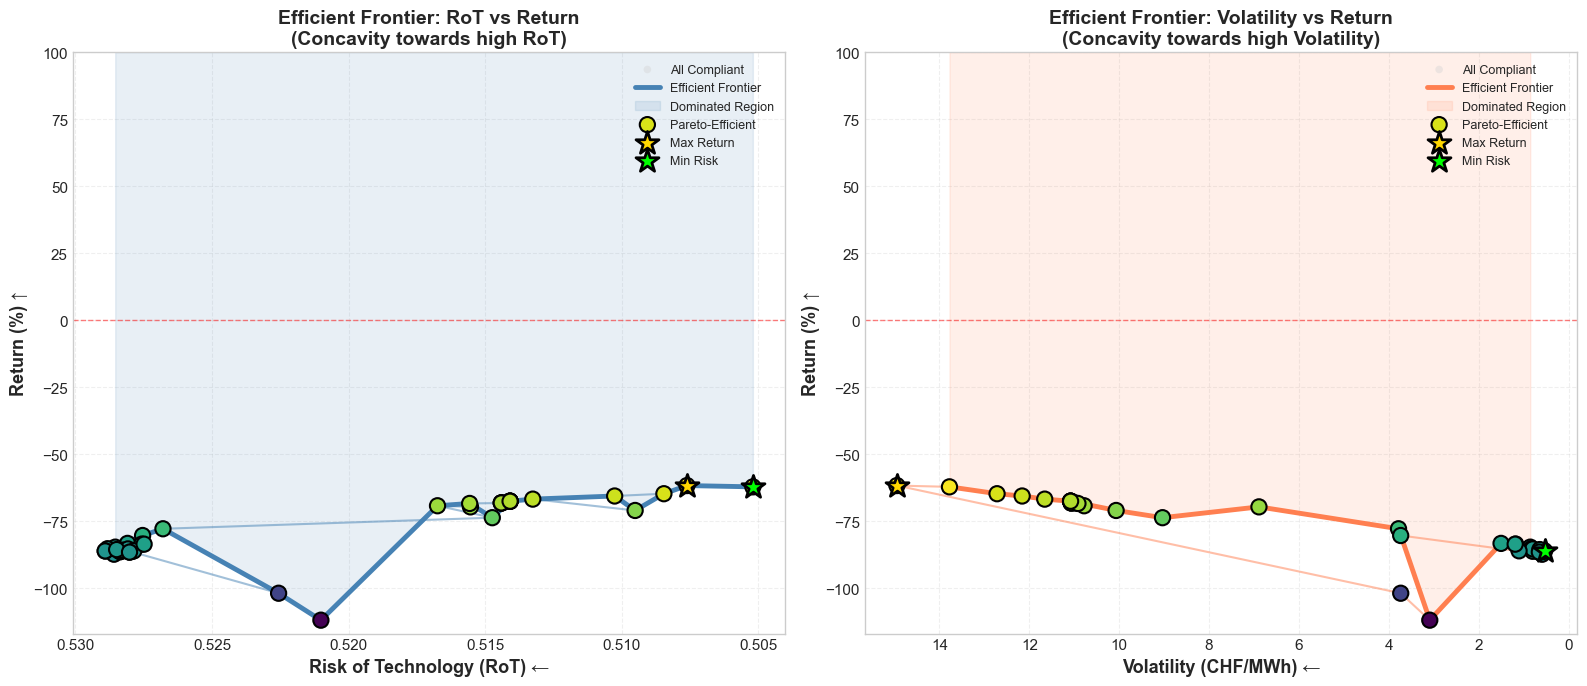


✅ Saved 2D projections to data/result_plots/efficient_frontier_2d_portfolio_theory.png

EFFICIENT FRONTIER ANALYSIS (Portfolio Theory)
  Risk (Vol, RoT) increases → on X-axis
  Return increases ↑ on Y-axis
  Frontier concavity opens towards (-Return, +Vol, +RoT)

📊 Portfolio Statistics:
   Total aviation-compliant: 43
   Pareto-efficient:        43 (100.0%)
   Convex hull vertices:    20

📈 Performance Ranges:
   Return:     [-111.87%, -61.66%]
   Volatility: [0.53, 14.95] CHF/MWh
   RoT:        [0.5052, 0.5289]

🏆 Optimal Pareto-Efficient Portfolios:
   ⭐ Max Return:  -61.66% (Vol=14.9, RoT=0.5076)
   🛡️  Min RoT:     0.5052 (Return=-62.14%, Vol=13.8)
   📊 Min Vol:     0.53 CHF/MWh (Return=-86.04%, RoT=0.5289)

📉 Efficient Frontier Trade-offs:
   RoT range:        0.0237 (0.5052 → 0.5289)
   Volatility range: 14.41 CHF/MWh (0.53 → 14.95)
   Return range:     50.21% (-111.87% → -61.66%)

📐 Frontier Edge Analysis (Nearest-Neighbor Path):
   RoT frontier edges:  42 connections
   Vol fr

In [22]:
# =============================================================================
# EFFICIENT FRONTIER: Portfolio Theory Style (Risk vs Return)
# =============================================================================
# Concavity: towards -return, +volatility, +RoT (standard portfolio theory)
# Axes: Risk metrics (Vol, RoT) increase left→right, Return increases bottom→top
# =============================================================================
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull, Delaunay
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

def plot_efficient_frontier_portfolio_theory():
    """
    Plot efficient frontier in STANDARD PORTFOLIO THEORY style:
    - X-axis: Risk metric (Volatility or RoT) increasing left → right
    - Y-axis: Return increasing bottom → top
    - Efficient frontier: Upper-left boundary (max return for given risk)
    - Curve fit: Hyperbolic/polynomial frontier like Markowitz
    
    Concavity: Bowl opens towards (-return, +vol, +RoT)
    """
    frontier_df = pd.read_csv('data/result_plots/multi_objective_results_frontier_3d.csv')
    
    # =========================================================================
    # FILTER TO FULLY COMPLIANT PORTFOLIOS ONLY
    # (Aviation + SOC + Electrical Sovereignty)
    # =========================================================================
    print("🔍 Filtering for fully compliant portfolios...")
    compliant_mask = frontier_df.apply(
        lambda row: is_portfolio_compliant(row.get('portfolio_dict', {}), row), 
        axis=1
    )
    compliant_df = frontier_df[compliant_mask].copy()
    
    print(f"   Total frontier portfolios: {len(frontier_df)}")
    print(f"   ✅ Fully compliant: {len(compliant_df)}")
    print(f"   ❌ Filtered: {len(frontier_df) - len(compliant_df)}")
    
    if len(compliant_df) < 4:
        print("❌ Not enough compliant portfolios for surface fitting")
        return
    
    # Extract data - PORTFOLIO THEORY CONVENTION:
    # Risk metrics (Vol, RoT) = "risk" → minimize but show increasing on X
    # Return = "reward" → maximize, show increasing on Y
    vol = compliant_df['y_volatility'].values   # Volatility (risk metric 1)
    rot = compliant_df['x_RoT'].values          # Risk of Technology (risk metric 2)
    ret = compliant_df['z_return'].values       # Return (reward)
    
    print(f"📊 Using {len(compliant_df)} aviation-compliant portfolios")
    print(f"   Portfolio Theory: Risk (Vol, RoT) on X-axis, Return on Y-axis")
    
    # =========================================================================
    # PREPARE DATA ARRAYS
    # =========================================================================
    points_2d = np.column_stack([vol, rot])
    points_3d = np.column_stack([vol, rot, ret])
    
    # =========================================================================
    # COMPUTE CONVEX HULLS
    # =========================================================================
    hull_2d = ConvexHull(points_2d)
    hull_3d = ConvexHull(points_3d)
    
    # =========================================================================
    # FIND PARETO-EFFICIENT PORTFOLIOS (Efficient Frontier)
    # =========================================================================
    # Portfolio i is Pareto-efficient if no other portfolio dominates it
    # Domination: j dominates i if (vol_j <= vol_i AND rot_j <= rot_i AND ret_j >= ret_i)
    #             with at least one strict inequality
    pareto_mask = np.ones(len(vol), dtype=bool)
    for i in range(len(vol)):
        for j in range(len(vol)):
            if i != j:
                # j dominates i if j is at least as good in all dimensions and strictly better in one
                vol_ok = vol[j] <= vol[i]
                rot_ok = rot[j] <= rot[i]
                ret_ok = ret[j] >= ret[i]
                
                if vol_ok and rot_ok and ret_ok:
                    # Check strict improvement in at least one
                    if vol[j] < vol[i] or rot[j] < rot[i] or ret[j] > ret[i]:
                        pareto_mask[i] = False
                        break
    
    pareto_vol = vol[pareto_mask]
    pareto_rot = rot[pareto_mask]
    pareto_ret = ret[pareto_mask]
    
    print(f"   Pareto-efficient portfolios: {pareto_mask.sum()}/{len(vol)}")
    
    # =========================================================================
    # UPPER FACES OF CONVEX HULL (for efficient frontier surface)
    # =========================================================================
    upper_faces = []
    for simplex in hull_3d.simplices:
        v0, v1, v2 = points_3d[simplex]
        edge1 = v1 - v0
        edge2 = v2 - v0
        normal = np.cross(edge1, edge2)
        norm_len = np.linalg.norm(normal)
        
        if norm_len > 1e-10:
            normal = normal / norm_len
            # Upper faces point upward (positive return direction)
            if normal[2] > 0.2:
                upper_faces.append(simplex)
    
    upper_faces = np.array(upper_faces) if len(upper_faces) > 0 else hull_3d.simplices
    
    # =========================================================================
    # 3D EFFICIENT FRONTIER SURFACE
    # Concavity: towards (-return, +vol, +RoT)
    # =========================================================================
    fig_3d = go.Figure()
    
    # 1. EFFICIENT FRONTIER SURFACE
    i = upper_faces[:, 0]
    j = upper_faces[:, 1]
    k = upper_faces[:, 2]
    fig_3d.add_trace(go.Mesh3d(
        x=vol, y=rot, z=ret,
        i=i, j=j, k=k,
        colorscale='Plasma',
        intensity=ret,
        intensitymode='vertex',
        opacity=0.65,
        colorbar=dict(title='Return (%)', x=1.02, len=0.7),
        name='Efficient Frontier',
        showscale=True,
        lighting=dict(ambient=0.4, diffuse=0.7, specular=0.5, roughness=0.2),
        hovertemplate='<b>Frontier Surface</b><br>Vol: %{x:.2f} CHF/MWh<br>RoT: %{y:.4f}<br>Return: %{z:.2f}%<extra></extra>'
    ))
    
    # 2. PARETO-EFFICIENT PORTFOLIOS
    fig_3d.add_trace(go.Scatter3d(
        x=pareto_vol, y=pareto_rot, z=pareto_ret,
        mode='markers',
        marker=dict(size=10, color=pareto_ret, colorscale='Viridis', symbol='diamond',
                   line=dict(width=2, color='white'), opacity=0.9),
        name=f'Pareto-Efficient ({len(pareto_vol)})',
        hovertemplate='<b>Efficient Portfolio</b><br>Vol: %{x:.2f}<br>RoT: %{y:.4f}<br>Return: %{z:.2f}%<extra></extra>'
    ))
    
    # 3. ALL COMPLIANT PORTFOLIOS
    fig_3d.add_trace(go.Scatter3d(
        x=vol, y=rot, z=ret,
        mode='markers',
        marker=dict(size=5, color='gray', symbol='circle', opacity=0.4),
        name=f'All Compliant ({len(vol)})',
        hovertemplate='<b>Portfolio</b><br>Vol: %{x:.2f}<br>RoT: %{y:.4f}<br>Return: %{z:.2f}%<extra></extra>'
    ))
    
    # Layout - show risk increasing left→right (standard portfolio theory)
    fig_3d.update_layout(
        title=dict(
            text='<b>3D Efficient Frontier (Portfolio Theory)</b><br>'
                 '<sup>Risk metrics increase ←, Return increases ↑, Concavity towards high risk</sup>',
            x=0.5
        ),
        scene=dict(
            xaxis=dict(title='Volatility (CHF/MWh) ←', backgroundcolor='#1a1a2e', gridcolor='#3a3a5a',
                      showbackground=True, tickfont=dict(color='white'), title_font=dict(color='white'), autorange='reversed'),
            yaxis=dict(title='Risk of Technology ←', backgroundcolor='#1a1a2e', gridcolor='#3a3a5a',
                      showbackground=True, tickfont=dict(color='white'), title_font=dict(color='white'), autorange='reversed'),
            zaxis=dict(title='Return (%) ↑', backgroundcolor='#1a1a2e', gridcolor='#3a3a5a',
                      showbackground=True, tickfont=dict(color='white'), title_font=dict(color='white')),
            camera=dict(eye=dict(x=-1.8, y=-1.8, z=0.8)),  # View from low-risk corner (adjusted for reversed axes)
            aspectmode='cube'
        ),
        paper_bgcolor='#0f0f1a',
        plot_bgcolor='#0f0f1a',
        font=dict(color='white'),
        margin=dict(l=0, r=50, t=100, b=0),
        height=750,
        legend=dict(x=0.02, y=0.98, bgcolor='rgba(30,30,50,0.9)', font=dict(color='white'))
    )
    fig_3d.show()
    
    # =========================================================================
    # 2D PROJECTIONS: Portfolio Theory Style
    # Efficient frontier = UPPER boundary (max return for given risk)
    # Concavity opens DOWNWARD towards -100% (infeasible region below)
    # =========================================================================
    
    def build_frontier_path_nearest_neighbor(risk_vals, return_vals):
        """
        Build efficient frontier path by connecting each portfolio to its nearest 
        unvisited neighbor. Returns ordered indices tracing the frontier edge.
        """
        n = len(risk_vals)
        if n == 0:
            return []
        
        # Normalize for distance calculation
        risk_norm = (risk_vals - risk_vals.min()) / (risk_vals.max() - risk_vals.min() + 1e-10)
        ret_norm = (return_vals - return_vals.min()) / (return_vals.max() - return_vals.min() + 1e-10)
        
        # Start from portfolio with minimum risk (leftmost on frontier)
        visited = [False] * n
        path = [np.argmin(risk_vals)]
        visited[path[0]] = True
        
        # Greedy nearest-neighbor traversal
        while len(path) < n:
            current = path[-1]
            best_next = -1
            best_dist = np.inf
            
            for j in range(n):
                if not visited[j]:
                    dist = np.sqrt((risk_norm[current] - risk_norm[j])**2 + 
                                  (ret_norm[current] - ret_norm[j])**2)
                    if dist < best_dist:
                        best_dist = dist
                        best_next = j
            
            if best_next >= 0:
                path.append(best_next)
                visited[best_next] = True
            else:
                break
        
        return path
    
    def get_upper_envelope(risk_vals, return_vals, n_bins=30):
        """
        Get upper envelope of the frontier (max return for each risk bin).
        This defines the efficient frontier boundary.
        """
        risk_min, risk_max = risk_vals.min(), risk_vals.max()
        bin_edges = np.linspace(risk_min, risk_max, n_bins + 1)
        
        envelope_risk = []
        envelope_return = []
        
        for i in range(len(bin_edges) - 1):
            mask = (risk_vals >= bin_edges[i]) & (risk_vals < bin_edges[i + 1])
            if mask.sum() > 0:
                # Take the MAXIMUM return in this bin (upper envelope)
                max_ret_idx = np.argmax(return_vals[mask])
                indices = np.where(mask)[0]
                envelope_risk.append(risk_vals[indices[max_ret_idx]])
                envelope_return.append(return_vals[indices[max_ret_idx]])
        
        return np.array(envelope_risk), np.array(envelope_return)
    
    # Build frontier paths using nearest-neighbor
    rot_path = build_frontier_path_nearest_neighbor(pareto_rot, pareto_ret)
    vol_path = build_frontier_path_nearest_neighbor(pareto_vol, pareto_ret)
    
    # Get upper envelopes for smooth frontier curves
    rot_env_x, rot_env_y = get_upper_envelope(pareto_rot, pareto_ret)
    vol_env_x, vol_env_y = get_upper_envelope(pareto_vol, pareto_ret)
    
    # Sort envelope points by risk for proper line drawing
    rot_sort_idx = np.argsort(rot_env_x)
    rot_env_x, rot_env_y = rot_env_x[rot_sort_idx], rot_env_y[rot_sort_idx]
    vol_sort_idx = np.argsort(vol_env_x)
    vol_env_x, vol_env_y = vol_env_x[vol_sort_idx], vol_env_y[vol_sort_idx]
    
    # Create 2D plots - PORTFOLIO THEORY STYLE
    fig_2d, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Determine y-axis limits (extend towards +100% for flipped infeasible region above)
    y_max = max(ret.max() + 20, 100)
    y_min = ret.min() - 5
    
    # -------------------------------------------------------------------------
    # Plot 1: RoT vs Return
    # Efficient frontier = upper boundary, concavity towards high RoT
    # -------------------------------------------------------------------------
    ax1 = axes[0]
    
    # All compliant portfolios (gray background)
    ax1.scatter(rot, ret, c='lightgray', alpha=0.4, s=30, label='All Compliant', edgecolors='none')
    
    # Draw nearest-neighbor edges between Pareto portfolios
    for i in range(len(rot_path) - 1):
        idx1, idx2 = rot_path[i], rot_path[i + 1]
        ax1.plot([pareto_rot[idx1], pareto_rot[idx2]], 
                [pareto_ret[idx1], pareto_ret[idx2]], 
                '-', color='steelblue', linewidth=1.5, alpha=0.5, zorder=4)
    
    # Upper envelope (efficient frontier) - thick line
    ax1.plot(rot_env_x, rot_env_y, '-', color='steelblue', linewidth=3.5, 
            label='Efficient Frontier', zorder=5)
    
    # Fill ABOVE the frontier (towards +100%) - this is now the infeasible/dominated region
    ax1.fill_between(rot_env_x, rot_env_y, y_max, alpha=0.12, color='steelblue', 
                    label='Dominated Region')
    
    # Pareto-efficient portfolios
    scatter1 = ax1.scatter(pareto_rot, pareto_ret, c=pareto_ret, cmap='viridis', s=120, 
                          edgecolors='black', linewidth=1.5, zorder=6, label='Pareto-Efficient')
    
    # Mark optimal portfolios
    best_ret_idx = np.argmax(pareto_ret)
    best_rot_idx = np.argmin(pareto_rot)
    ax1.scatter([pareto_rot[best_ret_idx]], [pareto_ret[best_ret_idx]], s=300, c='gold', 
               marker='*', edgecolors='black', linewidth=2, zorder=7, label='Max Return')
    ax1.scatter([pareto_rot[best_rot_idx]], [pareto_ret[best_rot_idx]], s=300, c='lime', 
               marker='*', edgecolors='black', linewidth=2, zorder=7, label='Min Risk')
    
    ax1.set_xlabel('Risk of Technology (RoT) ←', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Return (%) ↑', fontsize=13, fontweight='bold')
    ax1.set_title('Efficient Frontier: RoT vs Return\n(Concavity towards high RoT)', fontsize=14, fontweight='bold')
    ax1.set_ylim(y_min, y_max)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(loc='upper right', fontsize=9)
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)  # Break-even line
    ax1.invert_xaxis()  # Reverse x-axis for concavity towards high risk
    
    # -------------------------------------------------------------------------
    # Plot 2: Volatility vs Return
    # -------------------------------------------------------------------------
    ax2 = axes[1]
    
    # All compliant portfolios
    ax2.scatter(vol, ret, c='lightgray', alpha=0.4, s=30, label='All Compliant', edgecolors='none')
    
    # Draw nearest-neighbor edges
    for i in range(len(vol_path) - 1):
        idx1, idx2 = vol_path[i], vol_path[i + 1]
        ax2.plot([pareto_vol[idx1], pareto_vol[idx2]], 
                [pareto_ret[idx1], pareto_ret[idx2]], 
                '-', color='coral', linewidth=1.5, alpha=0.5, zorder=4)
    
    # Upper envelope (efficient frontier)
    ax2.plot(vol_env_x, vol_env_y, '-', color='coral', linewidth=3.5, 
            label='Efficient Frontier', zorder=5)
    
    # Fill ABOVE the frontier (towards +100%)
    ax2.fill_between(vol_env_x, vol_env_y, y_max, alpha=0.12, color='coral', 
                    label='Dominated Region')
    
    # Pareto-efficient portfolios
    scatter2 = ax2.scatter(pareto_vol, pareto_ret, c=pareto_ret, cmap='viridis', s=120, 
                          edgecolors='black', linewidth=1.5, zorder=6, label='Pareto-Efficient')
    
    # Mark optimal portfolios
    best_ret_idx_v = np.argmax(pareto_ret)
    best_vol_idx = np.argmin(pareto_vol)
    ax2.scatter([pareto_vol[best_ret_idx_v]], [pareto_ret[best_ret_idx_v]], s=300, c='gold', 
               marker='*', edgecolors='black', linewidth=2, zorder=7, label='Max Return')
    ax2.scatter([pareto_vol[best_vol_idx]], [pareto_ret[best_vol_idx]], s=300, c='lime', 
               marker='*', edgecolors='black', linewidth=2, zorder=7, label='Min Risk')
    
    ax2.set_xlabel('Volatility (CHF/MWh) ←', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Return (%) ↑', fontsize=13, fontweight='bold')
    ax2.set_title('Efficient Frontier: Volatility vs Return\n(Concavity towards high Volatility)', fontsize=14, fontweight='bold')
    ax2.set_ylim(y_min, y_max)
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.legend(loc='upper right', fontsize=9)
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)  # Break-even line
    ax2.invert_xaxis()  # Reverse x-axis for concavity towards high risk
    
    plt.tight_layout()
    from pathlib import Path
    output_path = Path('data/result_plots/efficient_frontier_2d_portfolio_theory.png')
    plt.savefig(output_path, dpi=150, facecolor='white', bbox_inches='tight')
    plt.show()
    
    print(f"\n✅ Saved 2D projections to {output_path}")
    
    # =========================================================================
    # STATISTICS
    # =========================================================================
    print(f"\n{'='*70}")
    print("EFFICIENT FRONTIER ANALYSIS (Portfolio Theory)")
    print("  Risk (Vol, RoT) increases → on X-axis")
    print("  Return increases ↑ on Y-axis")
    print("  Frontier concavity opens towards (-Return, +Vol, +RoT)")
    print('='*70)
    
    print(f"\n📊 Portfolio Statistics:")
    print(f"   Total aviation-compliant: {len(compliant_df)}")
    print(f"   Pareto-efficient:        {len(pareto_vol)} ({len(pareto_vol)/len(vol)*100:.1f}%)")
    print(f"   Convex hull vertices:    {len(hull_3d.vertices)}")
    
    print(f"\n📈 Performance Ranges:")
    print(f"   Return:     [{ret.min():.2f}%, {ret.max():.2f}%]")
    print(f"   Volatility: [{vol.min():.2f}, {vol.max():.2f}] CHF/MWh")
    print(f"   RoT:        [{rot.min():.4f}, {rot.max():.4f}]")
    
    # Find best portfolios on Pareto frontier
    best_return_idx = np.argmax(pareto_ret)
    best_rot_idx = np.argmin(pareto_rot)
    best_vol_idx = np.argmin(pareto_vol)
    
    print(f"\n🏆 Optimal Pareto-Efficient Portfolios:")
    print(f"   ⭐ Max Return:  {pareto_ret[best_return_idx]:.2f}% "
          f"(Vol={pareto_vol[best_return_idx]:.1f}, RoT={pareto_rot[best_return_idx]:.4f})")
    print(f"   🛡️  Min RoT:     {pareto_rot[best_rot_idx]:.4f} "
          f"(Return={pareto_ret[best_rot_idx]:.2f}%, Vol={pareto_vol[best_rot_idx]:.1f})")
    print(f"   📊 Min Vol:     {pareto_vol[best_vol_idx]:.2f} CHF/MWh "
          f"(Return={pareto_ret[best_vol_idx]:.2f}%, RoT={pareto_rot[best_vol_idx]:.4f})")
    
    # Trade-off analysis
    print(f"\n📉 Efficient Frontier Trade-offs:")
    rot_range = pareto_rot.max() - pareto_rot.min()
    vol_range = pareto_vol.max() - pareto_vol.min()
    return_range = pareto_ret.max() - pareto_ret.min()
    
    print(f"   RoT range:        {rot_range:.4f} ({pareto_rot.min():.4f} → {pareto_rot.max():.4f})")
    print(f"   Volatility range: {vol_range:.2f} CHF/MWh ({pareto_vol.min():.2f} → {pareto_vol.max():.2f})")
    print(f"   Return range:     {return_range:.2f}% ({pareto_ret.min():.2f}% → {pareto_ret.max():.2f}%)")
    
    # Frontier edge analysis
    print(f"\n📐 Frontier Edge Analysis (Nearest-Neighbor Path):")
    print(f"   RoT frontier edges:  {len(rot_path) - 1} connections")
    print(f"   Vol frontier edges:  {len(vol_path) - 1} connections")
    print(f"   Upper envelope bins: {len(rot_env_x)} (RoT), {len(vol_env_x)} (Vol)")
    
    print('='*70)

plot_efficient_frontier_portfolio_theory()

In [23]:
# =============================================================================
# 3D INTERACTIVE FRONTIER VISUALIZATION
# =============================================================================
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from ipywidgets import interact, Dropdown
from scipy.spatial import ConvexHull

def load_portfolio_data():
    """
    Load all portfolios and frontier portfolios, filtering for compliance.
    
    ONLY returns portfolios that satisfy ALL three hard constraints:
    - Aviation fuel capacity
    - Cyclic SOC (storage returns to initial state)
    - Electrical sovereignty (≥113 TWh/year)
    """
    all_df_raw = pd.read_csv('data/result_plots/multi_objective_results.csv')
    frontier_df_raw = pd.read_csv('data/result_plots/multi_objective_results_frontier_3d.csv')
    
    # Filter both dataframes for compliance
    all_compliant = all_df_raw.apply(
        lambda row: is_portfolio_compliant(row.get('portfolio_dict', {}), row), 
        axis=1
    )
    frontier_compliant = frontier_df_raw.apply(
        lambda row: is_portfolio_compliant(row.get('portfolio_dict', {}), row), 
        axis=1
    )
    
    all_df = all_df_raw[all_compliant].copy()
    frontier_df = frontier_df_raw[frontier_compliant].copy()
    
    print(f"📊 Loaded portfolios (compliance filtering):")
    print(f"   All: {len(all_df)} / {len(all_df_raw)} ({100*len(all_df)/len(all_df_raw):.1f}%)")
    print(f"   Frontier: {len(frontier_df)} / {len(frontier_df_raw)} ({100*len(frontier_df)/len(frontier_df_raw):.1f}%)")
    
    return all_df, frontier_df

def create_frontier_mesh(frontier_df):
    """Create convex hull mesh for frontier shape."""
    pts = frontier_df[['y_volatility', 'x_RoT', 'z_return']].values
    if len(pts) < 4:
        return None
    try:
        hull = ConvexHull(pts)
        return go.Mesh3d(
            x=pts[:, 0], y=pts[:, 1], z=pts[:, 2],
            i=hull.simplices[:, 0], j=hull.simplices[:, 1], k=hull.simplices[:, 2],
            opacity=0.25, color='steelblue', name='Frontier Hull'
        )
    except:
        return None

def plot_3d_frontier(view='Frontier Only'):
    """Interactive 3D scatter plot with toggle."""
    all_df, frontier_df = load_portfolio_data()
    fig = go.Figure()
    
    if view == 'All Portfolios':
        fig.add_trace(go.Scatter3d(
            x=all_df['y_volatility'], y=all_df['x_RoT'], z=all_df['z_return'],
            mode='markers',
            marker=dict(size=3, color=all_df['z_return'], colorscale='RdYlGn', opacity=0.4),
            name=f'All ({len(all_df)})',
            hovertemplate='Vol: %{x:.2f}<br>RoT: %{y:.4f}<br>Ret: %{z:.2f}%<extra></extra>'
        ))
    
    fig.add_trace(go.Scatter3d(
        x=frontier_df['y_volatility'], y=frontier_df['x_RoT'], z=frontier_df['z_return'],
        mode='markers',
        marker=dict(size=7, color=frontier_df['z_return'], colorscale='RdYlGn',
                   line=dict(width=1, color='black'), opacity=1.0,
                   colorbar=dict(title='Return %', x=1.02) if view != 'All Portfolios' else None),
        name=f'Frontier ({len(frontier_df)})',
        hovertemplate='<b>Frontier</b><br>Vol: %{x:.2f}<br>RoT: %{y:.4f}<br>Ret: %{z:.2f}%<extra></extra>'
    ))
    
    mesh = create_frontier_mesh(frontier_df)
    if mesh:
        fig.add_trace(mesh)
    
    # Corner portfolios
    corners = {
        'Best Return': frontier_df.loc[frontier_df['z_return'].idxmax()],
        'Lowest RoT': frontier_df.loc[frontier_df['x_RoT'].idxmin()],
        'Lowest Vol': frontier_df.loc[frontier_df['y_volatility'].idxmin()]
    }
    for name, row in corners.items():
        fig.add_trace(go.Scatter3d(
            x=[row['y_volatility']], y=[row['x_RoT']], z=[row['z_return']],
            mode='markers+text', text=[name], textposition='top center',
            marker=dict(size=10, symbol='diamond', color='gold', line=dict(width=2, color='black')),
            name=name, showlegend=True
        ))
    
    fig.update_layout(
        title=dict(text=f'<b>3D Pareto Frontier</b> ({view})', x=0.5),
        scene=dict(
            xaxis=dict(title='Volatility (CHF/MWh)'),
            yaxis=dict(title='Risk of Technology'),
            zaxis=dict(title='Return (%)'),
            camera=dict(eye=dict(x=1.5, y=1.5, z=0.8))
        ),
        legend=dict(x=0.02, y=0.98, bgcolor='rgba(255,255,255,0.8)'),
        margin=dict(l=0, r=0, t=50, b=0),
        height=650
    )
    fig.show()

interact(plot_3d_frontier, view=Dropdown(
    options=['Frontier Only', 'All Portfolios'],
    value='Frontier Only',
    description='View:'
))


interactive(children=(Dropdown(description='View:', options=('Frontier Only', 'All Portfolios'), value='Fronti…

<function __main__.plot_3d_frontier(view='Frontier Only')>

---

## 4. Interactive Portfolio Analysis

Select a portfolio from the Pareto frontier to run a **full-year simulation** and analyze:
- Incidence vs Demand (before storage) — matches Section 1.2c
- Dispatch results (after storage) — matches Section 1.3
- Energy production distribution by source
- Annual performance summary


In [33]:
# =============================================================================
# SECTION 4: Interactive Portfolio Analysis
# =============================================================================
import time
import json
from pathlib import Path
from IPython.display import clear_output, display
from ipywidgets import Dropdown, Button, Output, VBox, HBox, Layout, Label, HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PPU Framework
from ppu_framework import Portfolio

# Optimization & Config - import Config class for scenario switching
from optimization import Individual, evaluate_portfolio_full_year
from config import Config

# Data loader for reloading with new scenario
from data_loader import load_all_data

# Visualization
from visualization import (
    plot_full_year_production_by_source,
    plot_full_year_storage,
    plot_energy_balance_distribution
)

# =============================================================================
# DEMAND SCENARIO CONFIGURATION (2024 vs 2050)
# =============================================================================
# Select the demand scenario:
# - "2024": Base demand curve (113 TWh total, 23 TWh aviation)
# - "2050": 1.6× growth scenario (~181 TWh total, ~37 TWh aviation)

DEMAND_SCENARIO = "2024"  # ← CHANGE THIS TO "2050" FOR FUTURE SCENARIO

# Create config with selected scenario
config = Config()
config.energy_system.DEMAND_SCENARIO = DEMAND_SCENARIO

# Reload data with the selected scenario (force_reload to apply new multiplier)
_data = load_all_data(config, force_reload=True)

print(f"📊 Demand Scenario: {DEMAND_SCENARIO}")
print(f"   - Demand multiplier: {config.energy_system.DEMAND_MULTIPLIER}x")
print(f"   - Target demand: {config.energy_system.TARGET_ANNUAL_DEMAND_TWH:.1f} TWh/year")
print(f"   - Aviation fuel: {config.energy_system.AVIATION_FUEL_DEMAND_TWH_YEAR:.1f} TWh/year")


# =============================================================================
# Helper: Portfolio Compliance Check
# =============================================================================
def is_portfolio_compliant(portfolio_dict, row) -> bool:
    """Check if portfolio satisfies constraints (relaxed - no storage check)."""
    if isinstance(portfolio_dict, str):
        try:
            portfolio = json.loads(portfolio_dict)
        except:
            return False
    else:
        portfolio = portfolio_dict
    
    # 1. Aviation: THERM >= 263 + (SYN_FT or SYN_CRACK)
    MIN_THERM_FOR_AVIATION = 263
    therm_count = portfolio.get('THERM', 0)
    syn_ft_count = portfolio.get('SYN_FT', 0)
    syn_crack_count = portfolio.get('SYN_CRACK', 0)
    
    if not (therm_count >= MIN_THERM_FOR_AVIATION and (syn_ft_count > 0 or syn_crack_count > 0)):
        return False
    
    # 2. Sovereignty: >= 113 TWh
    if 'total_domestic_production_twh' in row:
        if row['total_domestic_production_twh'] < 113.0:
            return False
    
    # Storage constraint SKIPPED (CSV may have old tolerance)
    return True


# Load frontier portfolios
frontier_path = Path('data/result_plots/multi_objective_results_frontier_3d.csv')
if not frontier_path.exists():
    print("⚠️ Frontier CSV not found. Run Section 3.1 first to generate it.")
else:
    frontier_df_raw = pd.read_csv(frontier_path)
    
    # Filter for compliant portfolios only
    print("🔍 Filtering for compliant portfolios...")
    compliant_mask = frontier_df_raw.apply(
        lambda row: is_portfolio_compliant(row.get('portfolio_dict', {}), row), 
        axis=1
    )
    frontier_df = frontier_df_raw[compliant_mask].copy().reset_index(drop=True)
    
    print(f"   Total frontier portfolios: {len(frontier_df_raw)}")
    print(f"   ✅ Compliant portfolios: {len(frontier_df)}")
    print(f"   ❌ Filtered: {len(frontier_df_raw) - len(frontier_df)}")
    
    if len(frontier_df) == 0:
        print("\n⚠️ WARNING: No compliant portfolios found in frontier!")
        print("   Please re-run the optimization with the new constraints.")
    
    # Create dropdown options with portfolio summary
    portfolio_options = {}
    for idx, row in frontier_df.iterrows():
        label = f"#{int(idx)+1}: RoT={row['x_RoT']:.4f}, Vol={row['y_volatility']:.1f}, Ret={row['z_return']:.1f}%"
        portfolio_options[label] = int(idx)
    
    # Create widgets
    portfolio_dropdown = Dropdown(
        options=list(portfolio_options.keys()),
        value=list(portfolio_options.keys())[0],
        description='Portfolio:',
        style={'description_width': '80px'},
        layout=Layout(width='600px')
    )
    
    run_button = Button(
        description='🚀 Run Analysis',
        button_style='success',
        layout=Layout(width='150px', height='35px')
    )
    
    output_area = Output(layout=Layout(height='1000px', overflow='auto'))
    
    def run_portfolio_analysis(b):
        """Run full analysis for selected portfolio."""
        with output_area:
            clear_output(wait=True)
            
            # Get selected portfolio
            selected_idx = portfolio_options[portfolio_dropdown.value]
            row = frontier_df.iloc[selected_idx]
            
            print("=" * 70)
            print(f"ANALYZING PORTFOLIO #{selected_idx + 1}")
            print("=" * 70)
            print(f"  RoT:        {row['x_RoT']:.4f}")
            print(f"  Volatility: {row['y_volatility']:.2f} CHF/MWh")
            print(f"  Return:     {row['z_return']:.2f}%")
            
            # Parse portfolio dict
            portfolio_dict_str = row['portfolio_dict']
            if isinstance(portfolio_dict_str, str):
                portfolio_dict = json.loads(portfolio_dict_str)
            else:
                portfolio_dict = portfolio_dict_str
            
            print(f"\n📦 Portfolio composition:")
            for ppu, count in sorted(portfolio_dict.items(), key=lambda x: -x[1]):
                if count > 0:
                    print(f"    {ppu}: {count} units")
            
            # Run full year simulation
            print("\n⏳ Running full-year simulation (8,760 hours)...")
            individual = Individual(portfolio=Portfolio(ppu_counts=portfolio_dict))
            
            start_time = time.time()
            full_year_results = evaluate_portfolio_full_year(
                individual=individual,
                config=config,
                verbose=False
            )
            elapsed = time.time() - start_time
            print(f"✅ Simulation complete in {elapsed:.1f}s")
            
            # ================================================================
            # PART 1: Incidence vs Demand Analysis (Matches Section 1.2c)
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 1: INCIDENCE VS DEMAND ANALYSIS (Before Storage)")
            print("=" * 70)
            
            dem = np.array(full_year_results.demand)
            ren = np.array(full_year_results.renewable_production)
            balance = ren - dem
            
            # Statistics
            total_demand_twh = np.sum(dem) / 1e6
            total_renewable_twh = np.sum(ren) / 1e6
            coverage = (total_renewable_twh / total_demand_twh) * 100
            surplus_h = np.sum(balance > 0)
            deficit_h = np.sum(balance < 0)
            total_surplus_twh = np.sum(balance[balance > 0]) / 1e6
            total_deficit_twh = np.sum(balance[balance < 0]) / 1e6
            
            print(f"\n📊 Energy Summary:")
            print(f"   Total Demand:     {total_demand_twh:.2f} TWh")
            print(f"   Total Incidence:  {total_renewable_twh:.2f} TWh")
            print(f"   Coverage:         {coverage:.1f}%")
            print(f"\n⚡ Balance:")
            print(f"   Surplus hours:    {surplus_h:,} ({surplus_h/len(balance)*100:.1f}%)")
            print(f"   Deficit hours:    {deficit_h:,} ({deficit_h/len(balance)*100:.1f}%)")
            print(f"   Total surplus:    {total_surplus_twh:.2f} TWh (storable)")
            print(f"   Total deficit:    {abs(total_deficit_twh):.2f} TWh (need storage/dispatch)")

            fig1, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
            hours = np.arange(len(dem))
            days = hours / 24

            # Plot 1: Incidence vs Demand
            ax1 = axes[0]
            ax1.fill_between(days, dem/1e3, alpha=0.3, label='Demand', color='red')
            ax1.fill_between(days, ren/1e3, alpha=0.5, label='Incidence (Renewable)', color='green')
            ax1.set_ylabel('Power (GW)')
            ax1.set_title(f'Portfolio #{selected_idx+1}: Incidence Production vs Demand (Before Storage)')
            ax1.legend(loc='upper right')
            ax1.grid(True, alpha=0.3)

            # Plot 2: Balance (Surplus/Deficit)
            ax2 = axes[1]
            balance_gw = balance / 1e3
            ax2.fill_between(days, balance_gw, where=balance_gw >= 0, alpha=0.7, 
                              label='Surplus (storable)', color='green', interpolate=True)
            ax2.fill_between(days, balance_gw, where=balance_gw < 0, alpha=0.7, 
                              label='Deficit (need storage/dispatch)', color='red', interpolate=True)
            ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
            ax2.set_ylabel('Balance (GW)')
            ax2.set_title('Hourly Balance: Incidence - Demand')
            ax2.legend(loc='upper right')
            ax2.grid(True, alpha=0.3)

            # Plot 3: Cumulative Energy Balance
            ax3 = axes[2]
            cumulative_balance = np.cumsum(balance) / 1e6  # TWh cumulative
            ax3.plot(days, cumulative_balance, 'b-', linewidth=1.5, label='Cumulative Balance')
            ax3.fill_between(days, cumulative_balance, where=cumulative_balance >= 0, 
                              alpha=0.3, color='green')
            ax3.fill_between(days, cumulative_balance, where=cumulative_balance < 0, 
                              alpha=0.3, color='red')
            ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
            ax3.set_xlabel('Day of Year')
            ax3.set_ylabel('Cumulative Balance (TWh)')
            ax3.set_title('Cumulative Energy Balance (shows seasonal storage need)')
            ax3.legend(loc='upper right')
            ax3.grid(True, alpha=0.3)

            # Add month labels
            month_starts = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]
            month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
            ax3.set_xticks(month_starts)
            ax3.set_xticklabels(month_labels)
            
            plt.tight_layout()
            plt.show()

            print("\n" + "=" * 70)
            print("KEY INSIGHT: The cumulative balance shows the seasonal storage requirement.")
            print("- Deepest negative point = minimum seasonal storage needed")
            print(f"- In this portfolio: {-np.min(cumulative_balance):.1f} TWh seasonal storage required")
            print("=" * 70)

            # ================================================================
            # PART 2: Dispatch Results (Matches Section 1.3)
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 2: DISPATCH RESULTS (After Storage/Dispatch)")
            print("=" * 70)
            
            plot_full_year_production_by_source(
                full_year_results,
                title=f"Portfolio #{selected_idx+1}: Hourly Production Stack vs Demand"
            )
            plt.show()
            
            plot_full_year_storage(
                full_year_results,
                title=f"Portfolio #{selected_idx+1}: Storage State of Charge - Full Year"
            )
            plt.show()
            
            plot_energy_balance_distribution(
                demand=full_year_results.demand,
                production=full_year_results.renewable_production,
                renewable_production=full_year_results.renewable_production,
                title=f"Portfolio #{selected_idx+1}: Renewable vs Demand (Gap = Storage + Dispatchable)"
            )
            plt.show()

            # ================================================================
            # PART 3: PPU DECOMPOSITION BY CATEGORY
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 3: PPU DECOMPOSITION BY CATEGORY")
            print("=" * 70)
            
            # Define PPU categories (from config)
            INCIDENCE_PPUS = ['PV', 'WD_ON', 'WD_OFF', 'HYD_R', 'BIO_WOOD']
            FLEX_PPUS = ['HYD_S', 'THERM', 'H2P_G', 'H2P_L', 'SOL_SALT', 'SOL_STEAM', 
                        'PALM_ICE', 'IMP_BIOG', 'THERM_CH4', 'NH3_P']
            STORAGE_PPUS = ['PHS', 'H2_G', 'H2_GL', 'H2_L', 'SYN_FT', 'SYN_METH', 
                          'NH3_FULL', 'SYN_CRACK', 'CH4_BIO', 'SOL_SALT_STORE']
            
            # Get production and consumption data
            ppu_production = full_year_results.ppu_production
            ppu_consumption = full_year_results.ppu_consumption  # NEW: energy consumed by storage INPUT PPUs
            
            # --- 3.1 Numerical Decomposition (Unit Counts) ---
            print("\n📊 NUMERICAL DECOMPOSITION (Unit Counts):")
            
            def analyze_category(cat_name, ppu_list, portfolio_dict, ppu_production, ppu_consumption=None, use_consumption=False):
                """Analyze PPU category - use consumption for storage INPUT PPUs."""
                cat_counts = {p: portfolio_dict.get(p, 0) for p in ppu_list if portfolio_dict.get(p, 0) > 0}
                
                # For storage INPUT PPUs, use consumption (energy absorbed), not production
                data_source = ppu_consumption if (use_consumption and ppu_consumption) else ppu_production
                
                cat_energy = {}
                for p in ppu_list:
                    if p in data_source:
                        energy_mwh = np.sum(data_source.get(p, [0]))
                        if energy_mwh > 0:
                            cat_energy[p] = energy_mwh / 1e6  # Convert to TWh
                
                total_units = sum(cat_counts.values())
                total_energy = sum(cat_energy.values())
                return cat_counts, cat_energy, total_units, total_energy
            
            inc_counts, inc_energy, inc_total_units, inc_total_twh = analyze_category(
                "INCIDENCE", INCIDENCE_PPUS, portfolio_dict, ppu_production, ppu_consumption, use_consumption=False)
            flex_counts, flex_energy, flex_total_units, flex_total_twh = analyze_category(
                "FLEX", FLEX_PPUS, portfolio_dict, ppu_production, ppu_consumption, use_consumption=False)
            # STORAGE INPUT PPUs: use ppu_consumption to show energy handled (charged into storage)
            stor_counts, stor_energy, stor_total_units, stor_total_twh = analyze_category(
                "STORAGE", STORAGE_PPUS, portfolio_dict, ppu_production, ppu_consumption, use_consumption=True)
            
            grand_total_units = inc_total_units + flex_total_units + stor_total_units
            grand_total_twh = inc_total_twh + flex_total_twh + stor_total_twh
            
            print(f"\n   {'Category':<12} | {'Units':>8} | {'% of Total':>10} | {'Energy (TWh)':>12} | {'% of Energy':>11}")
            print(f"   {'-'*12}-+-{'-'*8}-+-{'-'*10}-+-{'-'*12}-+-{'-'*11}")
            print(f"   {'INCIDENCE':<12} | {inc_total_units:>8} | {inc_total_units/grand_total_units*100 if grand_total_units else 0:>9.1f}% | {inc_total_twh:>12.2f} | {inc_total_twh/grand_total_twh*100 if grand_total_twh else 0:>10.1f}%")
            print(f"   {'FLEX':<12} | {flex_total_units:>8} | {flex_total_units/grand_total_units*100 if grand_total_units else 0:>9.1f}% | {flex_total_twh:>12.2f} | {flex_total_twh/grand_total_twh*100 if grand_total_twh else 0:>10.1f}%")
            print(f"   {'STORAGE':<12} | {stor_total_units:>8} | {stor_total_units/grand_total_units*100 if grand_total_units else 0:>9.1f}% | {stor_total_twh:>12.2f} | {stor_total_twh/grand_total_twh*100 if grand_total_twh else 0:>10.1f}%")
            print(f"   {'-'*12}-+-{'-'*8}-+-{'-'*10}-+-{'-'*12}-+-{'-'*11}")
            print(f"   {'TOTAL':<12} | {grand_total_units:>8} | {'100.0':>9}% | {grand_total_twh:>12.2f} | {'100.0':>10}%")
            
            print("\n   ℹ️  Note: STORAGE energy shows electricity consumed for charging (not produced)")
            
            # --- 3.2 Detailed Breakdown by Category ---
            def print_category_detail(cat_name, counts, energy, total_units, total_twh, color, is_storage=False):
                energy_label = "absorbed" if is_storage else "produced"
                print(f"\n   🔹 {cat_name} PPUs ({energy_label}):")
                if not counts:
                    print(f"      (none in portfolio)")
                    return
                for ppu in sorted(counts.keys(), key=lambda x: -counts[x]):
                    unit_pct = counts[ppu] / total_units * 100 if total_units else 0
                    energy_twh = energy.get(ppu, 0)
                    energy_pct = energy_twh / total_twh * 100 if total_twh else 0
                    print(f"      {ppu:<15}: {counts[ppu]:>5} units ({unit_pct:>5.1f}%) | {energy_twh:>6.2f} TWh ({energy_pct:>5.1f}%)")
            
            print_category_detail("INCIDENCE", inc_counts, inc_energy, inc_total_units, inc_total_twh, 'green', is_storage=False)
            print_category_detail("FLEX (Dispatchable)", flex_counts, flex_energy, flex_total_units, flex_total_twh, 'orange', is_storage=False)
            print_category_detail("STORAGE (Input)", stor_counts, stor_energy, stor_total_units, stor_total_twh, 'blue', is_storage=True)
            
            # --- 3.3 Visualization: Category Decomposition ---
            fig_cat, axes_cat = plt.subplots(1, 3, figsize=(16, 5))
            
            # Pie chart: Units by Category
            ax1 = axes_cat[0]
            cat_units = [inc_total_units, flex_total_units, stor_total_units]
            cat_labels = ['INCIDENCE', 'FLEX', 'STORAGE']
            cat_colors = ['#2ecc71', '#e67e22', '#3498db']
            if sum(cat_units) > 0:
                wedges, texts, autotexts = ax1.pie(cat_units, labels=cat_labels, autopct='%1.1f%%',
                                                   colors=cat_colors, explode=[0.02]*3)
                ax1.set_title('Unit Distribution by Category')
            
            # Pie chart: Energy by Category
            ax2 = axes_cat[1]
            cat_twh = [inc_total_twh, flex_total_twh, stor_total_twh]
            if sum(cat_twh) > 0:
                wedges, texts, autotexts = ax2.pie(cat_twh, labels=cat_labels, autopct='%1.1f%%',
                                                   colors=cat_colors, explode=[0.02]*3)
                ax2.set_title('Energy Production by Category (TWh)')
            
            # Bar chart: Top 10 PPUs by Energy
            ax3 = axes_cat[2]
            all_energy = {**inc_energy, **flex_energy, **stor_energy}
            sorted_energy = sorted(all_energy.items(), key=lambda x: -x[1])[:10]
            if sorted_energy:
                ppus = [x[0] for x in sorted_energy]
                twhs = [x[1] for x in sorted_energy]
                colors_bar = []
                for p in ppus:
                    if p in INCIDENCE_PPUS: colors_bar.append('#2ecc71')
                    elif p in FLEX_PPUS: colors_bar.append('#e67e22')
                    else: colors_bar.append('#3498db')
                ax3.barh(range(len(ppus)), twhs, color=colors_bar)
                ax3.set_yticks(range(len(ppus)))
                ax3.set_yticklabels(ppus)
                ax3.invert_yaxis()
                ax3.set_xlabel('Energy (TWh)')
                ax3.set_title('Top 10 PPUs by Energy Production')
                ax3.grid(True, alpha=0.3, axis='x')
            
            plt.tight_layout()
            plt.show()
            
            # ================================================================
            # PART 4: HOURLY ENERGY MIX (Daily Average Profile)
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 4: HOURLY ENERGY MIX (Daily Average Profile)")
            print("=" * 70)
            
            # Build hourly production by PPU (shape: n_hours x n_ppus)
            n_hours = len(full_year_results.demand)
            n_days = n_hours // 24
            demand_array = np.array(full_year_results.demand)  # Needed for demand overlay
            
            # Get all PPUs with production
            active_ppus = [p for p in ppu_production.keys() 
                          if isinstance(ppu_production[p], np.ndarray) and len(ppu_production[p]) == n_hours]
            
            # Calculate average production by hour of day for each PPU
            hourly_avg_by_ppu = {}
            for ppu in active_ppus:
                prod = np.array(ppu_production[ppu])[:n_days*24]
                # Reshape to (n_days, 24) and take mean over days
                prod_reshaped = prod.reshape(n_days, 24)
                hourly_avg_by_ppu[ppu] = np.mean(prod_reshaped, axis=0)  # shape: (24,)
            
            # Sort PPUs by total daily production
            ppu_daily_totals = {p: np.sum(hourly_avg_by_ppu[p]) for p in hourly_avg_by_ppu}
            sorted_ppus = sorted(ppu_daily_totals.keys(), key=lambda x: -ppu_daily_totals[x])
            
            # Print hourly mix table for key hours
            print("\n📊 AVERAGE HOURLY ENERGY MIX (MW by PPU):")
            key_hours = [0, 6, 8, 12, 14, 18, 20, 22]
            
            # Header
            header = f"   {'PPU':<15}"
            for h in key_hours:
                header += f" | {h:02d}:00"
            print(header)
            print(f"   {'-'*15}" + "-+-" + "-+-".join(["-"*6]*len(key_hours)))
            
            # Print top 10 PPUs
            for ppu in sorted_ppus[:12]:
                row = f"   {ppu:<15}"
                for h in key_hours:
                    val = hourly_avg_by_ppu[ppu][h]
                    if val >= 1000:
                        row += f" | {val/1e3:5.1f}k"
                    else:
                        row += f" | {val:6.0f}"
                print(row)
            
            # --- 4.1 Stacked Area Chart: Hourly Mix ---
            fig_hourly, ax_hourly = plt.subplots(figsize=(14, 8))
            
            hours_x = np.arange(24)
            # Get top PPUs for visualization (to avoid too many)
            top_ppus = sorted_ppus[:8]
            other_ppus = sorted_ppus[8:]
            
            # Stack the production
            bottom = np.zeros(24)
            colors_hourly = plt.cm.tab20(np.linspace(0, 1, len(top_ppus) + 1))
            
            for i, ppu in enumerate(top_ppus):
                values = hourly_avg_by_ppu[ppu] / 1e3  # GW
                ax_hourly.fill_between(hours_x, bottom, bottom + values, 
                                       label=ppu, alpha=0.8, color=colors_hourly[i])
                ax_hourly.plot(hours_x, bottom + values, color='white', linewidth=0.5)
                bottom += values
            
            # Add "Other" if exists
            if other_ppus:
                other_sum = np.sum([hourly_avg_by_ppu[p] for p in other_ppus], axis=0) / 1e3
                ax_hourly.fill_between(hours_x, bottom, bottom + other_sum, 
                                       label='Other', alpha=0.6, color='gray')
                bottom += other_sum
            
            # Add demand line
            demand_hourly_avg = np.array([np.mean(demand_array[h::24]) for h in range(24)]) / 1e3
            ax_hourly.plot(hours_x, demand_hourly_avg, 'r--', linewidth=2.5, label='Avg Demand')
            
            ax_hourly.set_xlabel('Hour of Day', fontsize=12)
            ax_hourly.set_ylabel('Power (GW)', fontsize=12)
            ax_hourly.set_title(f'Portfolio #{selected_idx+1}: Average Daily Energy Mix by Source', fontsize=14)
            ax_hourly.set_xticks(range(0, 24, 2))
            ax_hourly.set_xlim(0, 23)
            ax_hourly.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10)
            ax_hourly.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # ================================================================
            # PART 5: SOLAR/WIND PRODUCTION CONCENTRATION 3D ANALYSIS
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 5: SOLAR/WIND PRODUCTION CONCENTRATION (3D Analysis)")
            print("=" * 70)
            print("Analyzing how production is distributed across locations per timestep...")
            print("X = Total production at timestep")
            print("Y = % of locations needed to reach 90% of that timestep's production")
            print("Z = Number of occurrences (frequency)")
            
            from mpl_toolkits.mplot3d import Axes3D
            
            # Get location-level incidence data
            solar_incidence = _data.get_solar_incidence(copy=False)  # Shape: (n_hours, n_locations)
            wind_incidence = _data.get_wind_incidence(copy=False)    # Shape: (n_hours, n_locations)
            
            solar_units = portfolio_dict.get('PV', 0)
            wind_on_units = portfolio_dict.get('WD_ON', 0)
            wind_off_units = portfolio_dict.get('WD_OFF', 0)
            
            mw_per_unit = config.ppu.MW_PER_UNIT  # 10 MW per unit
            
            def compute_location_concentration(incidence_data, n_units, n_hours_data):
                """
                For each timestep, calculate:
                - Total production across all locations
                - % of locations needed to reach 90% of that timestep's production
                
                Returns: (productions, pct_locations_for_90, valid_mask)
                """
                n_hours_inc, n_locations = incidence_data.shape
                n_hours_use = min(n_hours_data, n_hours_inc)
                
                # Use top n_units locations (sorted by ranking in data loader)
                n_locs_used = min(n_units, n_locations)
                if n_locs_used == 0:
                    return None, None, None
                
                # Production per location per hour (MW) - incidence * capacity
                # Each unit = mw_per_unit MW, distributed across locations
                prod_per_loc = incidence_data[:n_hours_use, :n_locs_used] * mw_per_unit  # Shape: (n_hours, n_locs)
                
                productions = []
                pct_for_90 = []
                
                for t in range(n_hours_use):
                    loc_prod = prod_per_loc[t, :]  # Production at each location this hour
                    total_prod = np.sum(loc_prod)
                    
                    if total_prod < 1.0:  # Skip hours with negligible production
                        continue
                    
                    # Sort locations by production (descending)
                    sorted_prod = np.sort(loc_prod)[::-1]
                    cumsum = np.cumsum(sorted_prod)
                    
                    # Find % of locations needed to reach 90%
                    threshold_90 = 0.9 * total_prod
                    n_locs_for_90 = np.searchsorted(cumsum, threshold_90) + 1
                    pct_locs = (n_locs_for_90 / n_locs_used) * 100
                    
                    productions.append(total_prod)
                    pct_for_90.append(pct_locs)
                
                return np.array(productions), np.array(pct_for_90), True
            
            # --- 5.1 Compute concentration for Solar ---
            print("\n🔆 SOLAR PV CONCENTRATION:")
            if solar_units > 0:
                solar_prod_arr, solar_pct_90, solar_valid = compute_location_concentration(
                    solar_incidence, solar_units, n_hours)
                
                if solar_valid and len(solar_prod_arr) > 0:
                    print(f"   Units: {solar_units} | Locations used: {min(solar_units, solar_incidence.shape[1])}")
                    print(f"   Hours with production: {len(solar_prod_arr):,}")
                    print(f"   Avg % locations for 90%: {np.mean(solar_pct_90):.1f}%")
                    print(f"   Min % locations for 90%: {np.min(solar_pct_90):.1f}% (most concentrated)")
                    print(f"   Max % locations for 90%: {np.max(solar_pct_90):.1f}% (most distributed)")
            else:
                print("   No Solar PV in portfolio")
                solar_prod_arr, solar_pct_90 = None, None
            
            # --- 5.2 Compute concentration for Wind ---
            print("\n💨 WIND CONCENTRATION:")
            wind_total_units = wind_on_units + wind_off_units
            if wind_total_units > 0:
                wind_prod_arr, wind_pct_90, wind_valid = compute_location_concentration(
                    wind_incidence, wind_total_units, n_hours)
                
                if wind_valid and len(wind_prod_arr) > 0:
                    print(f"   Units: {wind_total_units} | Locations used: {min(wind_total_units, wind_incidence.shape[1])}")
                    print(f"   Hours with production: {len(wind_prod_arr):,}")
                    print(f"   Avg % locations for 90%: {np.mean(wind_pct_90):.1f}%")
                    print(f"   Min % locations for 90%: {np.min(wind_pct_90):.1f}% (most concentrated)")
                    print(f"   Max % locations for 90%: {np.max(wind_pct_90):.1f}% (most distributed)")
            else:
                print("   No Wind in portfolio")
                wind_prod_arr, wind_pct_90 = None, None
            
            # --- 5.3 Create 3D Histogram Plots ---
            fig_3d = plt.figure(figsize=(16, 6))
            
            def plot_3d_concentration(ax, prod_arr, pct_90_arr, title, color):
                """Create 3D histogram: X=production, Y=%locations for 90%, Z=frequency"""
                if prod_arr is None or len(prod_arr) == 0:
                    ax.text2D(0.5, 0.5, f'No data for {title}', ha='center', va='center', 
                             transform=ax.transAxes, fontsize=12)
                    ax.set_title(title)
                    return
                
                # Create 2D histogram bins
                n_bins_x = 25  # Production bins
                n_bins_y = 20  # % locations bins
                
                # Bin edges
                x_edges = np.linspace(0, np.percentile(prod_arr, 99), n_bins_x + 1)
                y_edges = np.linspace(0, 100, n_bins_y + 1)
                
                # Compute 2D histogram
                hist, x_edges, y_edges = np.histogram2d(
                    prod_arr / 1e3,  # Convert to GW
                    pct_90_arr,
                    bins=[x_edges / 1e3, y_edges]
                )
                
                # Create meshgrid for 3D bars
                x_centers = (x_edges[:-1] + x_edges[1:]) / 2
                y_centers = (y_edges[:-1] + y_edges[1:]) / 2
                x_width = x_edges[1] - x_edges[0]
                y_width = y_edges[1] - y_edges[0]
                
                # Plot as 3D bars
                xpos, ypos = np.meshgrid(x_centers, y_centers, indexing='ij')
                xpos = xpos.flatten()
                ypos = ypos.flatten()
                zpos = np.zeros_like(xpos)
                
                dx = x_width * 0.8 * np.ones_like(xpos)
                dy = y_width * 0.8 * np.ones_like(ypos)
                dz = hist.flatten()
                
                # Only plot non-zero bars
                mask = dz > 0
                if np.sum(mask) > 0:
                    # Color by frequency
                    colors_3d = plt.cm.viridis(dz[mask] / np.max(dz[mask]))
                    ax.bar3d(xpos[mask], ypos[mask], zpos[mask], 
                            dx[mask], dy[mask], dz[mask],
                            color=colors_3d, alpha=0.8, edgecolor='white', linewidth=0.2)
                
                ax.set_xlabel('Production (GW)', fontsize=10)
                ax.set_ylabel('% Locations for 90%', fontsize=10)
                ax.set_zlabel('Hours (freq)', fontsize=10)
                ax.set_title(title, fontsize=12, fontweight='bold')
                ax.view_init(elev=25, azim=45)
            
            # Solar 3D plot
            ax1 = fig_3d.add_subplot(121, projection='3d')
            plot_3d_concentration(ax1, solar_prod_arr, solar_pct_90, 'Solar PV: Production Concentration', 'gold')
            
            # Wind 3D plot
            ax2 = fig_3d.add_subplot(122, projection='3d')
            plot_3d_concentration(ax2, wind_prod_arr, wind_pct_90, 'Wind: Production Concentration', 'skyblue')
            
            plt.tight_layout()
            plt.show()
            
            # --- 5.4 2D Heatmap Alternative (easier to read) ---
            fig_heat, axes_heat = plt.subplots(1, 2, figsize=(14, 5))
            
            def plot_2d_heatmap(ax, prod_arr, pct_90_arr, title):
                # Check for None or empty arrays
                if prod_arr is None or pct_90_arr is None:
                    ax.text(0.5, 0.5, 'No data available', ha='center', va='center', 
                           transform=ax.transAxes, fontsize=12)
                    ax.set_title(title)
                    return
                
                if len(prod_arr) == 0 or len(pct_90_arr) == 0:
                    ax.text(0.5, 0.5, 'No production hours', ha='center', va='center', 
                           transform=ax.transAxes, fontsize=12)
                    ax.set_title(title)
                    return
                
                # Check for valid data range
                max_prod = np.percentile(prod_arr, 99)
                if max_prod <= 0 or not np.isfinite(max_prod):
                    ax.text(0.5, 0.5, 'No significant production', ha='center', va='center', 
                           transform=ax.transAxes, fontsize=12)
                    ax.set_title(title)
                    return
                
                n_bins = 30
                x_edges = np.linspace(0, max_prod, n_bins + 1)
                y_edges = np.linspace(0, 100, n_bins + 1)
                
                hist, _, _ = np.histogram2d(prod_arr / 1e3, pct_90_arr, bins=[x_edges / 1e3, y_edges])
                
                im = ax.imshow(hist.T, origin='lower', aspect='auto',
                              extent=[x_edges[0]/1e3, x_edges[-1]/1e3, 0, 100],
                              cmap='YlOrRd')
                plt.colorbar(im, ax=ax, label='Hours (frequency)')
                ax.set_xlabel('Total Production (GW)')
                ax.set_ylabel('% Locations for 90% of Production')
                ax.set_title(title)
                
                # Add average line
                avg_pct = np.mean(pct_90_arr)
                if np.isfinite(avg_pct):
                    ax.axhline(avg_pct, color='cyan', linestyle='--', linewidth=2,
                              label=f'Avg: {avg_pct:.0f}%')
                    ax.legend(loc='upper right')
            
            plot_2d_heatmap(axes_heat[0], solar_prod_arr, solar_pct_90, 
                           'Solar PV: Concentration Heatmap')
            plot_2d_heatmap(axes_heat[1], wind_prod_arr, wind_pct_90, 
                           'Wind: Concentration Heatmap')
            
            plt.tight_layout()
            plt.show()
            
            print("\n📊 INTERPRETATION:")
            print("   - Lower % = Production concentrated in fewer locations (some sites dominate)")
            print("   - Higher % = Production distributed evenly across locations")
            print("   - High production + Low % = Peak hours rely on best sites")
            print("   - Low production + High % = Low-resource hours spread thin")
            
            # ================================================================
            # PART 6: Annual Performance Summary
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 6: ANNUAL PERFORMANCE SUMMARY")
            print("=" * 70)
            
            total_demand_twh = np.sum(full_year_results.demand) / 1e6
            total_prod_twh = np.sum(full_year_results.total_production) / 1e6
            total_ren_twh = np.sum(full_year_results.renewable_production) / 1e6
            
            print(f"\n📊 Energy Balance:")
            print(f"   Total Demand:       {total_demand_twh:.2f} TWh")
            print(f"   Total Production:   {total_prod_twh:.2f} TWh")
            print(f"   Renewable Only:     {total_ren_twh:.2f} TWh")
            print(f"   Spot Bought:        {full_year_results.total_spot_bought_mwh/1e6:.2f} TWh")
            print(f"   Spot Sold:          {full_year_results.total_spot_sold_mwh/1e6:.2f} TWh")
            
            print(f"\n💰 Spot Market Financials:")
            print(f"   Net Spot Cost:      {full_year_results.total_spot_cost_chf/1e9:.2f} B CHF")
            
            deficit_hours_count = np.sum(full_year_results.deficit > 0)
            surplus_hours_count = np.sum(full_year_results.surplus > 0)
            print(f"\n⚡ Grid Balance (after dispatch):")
            print(f"   Hours in Deficit:   {deficit_hours_count} h ({deficit_hours_count/8760*100:.1f}%)")
            print(f"   Hours in Surplus:   {surplus_hours_count} h ({surplus_hours_count/8760*100:.1f}%)")
            
            # Aviation fuel - use config value for target
            av_consumed = full_year_results.aviation_fuel_consumed_mwh / 1e6
            av_target = config.energy_system.AVIATION_FUEL_DEMAND_TWH_YEAR
            print(f"\n✈️  Aviation Fuel:")
            print(f"   Consumed:           {av_consumed:.2f} TWh")
            print(f"   Target:             {av_target:.2f} TWh")
            print(f"   Constraint Met:     {'✅ Yes' if av_consumed >= av_target * 0.99 else '❌ No'}")
            
            print("\n" + "=" * 70)
            print("✅ Analysis complete!")
            print("=" * 70)
    
    # Connect button
    run_button.on_click(run_portfolio_analysis)
    
    # Display widgets
    from IPython.display import display
    display(VBox([
        Label("Select a portfolio from the Pareto frontier:"),
        HBox([portfolio_dropdown, run_button]),
        output_area
    ]))

Loading data files...
  - Solar incidence: (9072, 1150)
  - Wind data loaded (mean: 1.3 m/s, no scaling)
  - Wind incidence: (9072, 1150)
  - Spot prices (EUR): (8784,)
  - Demand: (8784,)
  - Hydro data loaded
  - Cost data loaded (LCOE: 26 PPUs)
  - EUR/CHF rates: 366 days
  - Palm oil prices (CHF/MWh): 366 days, avg 100.79
  - Water inflow: 8784 hours, total 42.74 TWh
  - Spot prices converted to CHF: avg 72.07 CHF/MWh
  - Aligned all data to 8784 timesteps (366 days)
Data loading complete! (Demand scenario: 2024, multiplier: 1.0x)
📊 Demand Scenario: 2024
   - Demand multiplier: 1.0x
   - Target demand: 113.0 TWh/year
   - Aviation fuel: 23.0 TWh/year
🔍 Filtering for compliant portfolios...
   Total frontier portfolios: 43
   ✅ Compliant portfolios: 43
   ❌ Filtered: 0


---

## Summary

This notebook provides a complete framework for:

0. **External Data Overview:** Visualization of all input data (solar, wind, spot price, palm oil, etc.)
1. **Dispatch Simulation:** Full year hourly simulation with storage management
2. **Genetic Optimization:** Multi-objective portfolio optimization
3. **Pareto Analysis:** 3D frontier identification and visualization

### Key Features (v2.0)
- **Palm oil only:** Biooil removed; Palm oil is the only imported bio-fuel
- **Aviation fuel from Fuel Tank:** Synthetic fuel supplies 23 TWh/year aviation requirement
- **Dynamic pricing:** Palm oil prices from REA Holdings futures (USD/ton → CHF/MWh)
- **Water inflow to lakes:** Precipitation-based inflow at 0.9 kWh/m³
- **EUR→CHF conversion:** Spot prices converted using daily exchange rates
- **LCOE from analysis:** Pre-computed efficiency and costs with parallelism
- Storage capacity caps (50 TWh for H2/CH4/NH3, 25 TWh for Fuel/Biogas)
- Ghost PPU mechanism for palm oil import regulation
- 3D Pareto frontier (RoT, Volatility, Return)

### Output Files
- `data/result_plots/external_data_overview.png` - External data visualization
- `data/result_plots/multi_objective_results.csv` - All evaluated portfolios
- `data/result_plots/multi_objective_results_final_frontier_3d.csv` - Pareto frontier
- Various PNG visualizations
